<div align="center">

# News Authentication Via Emotion (NAVE)

**Alexander Epstein**

**Northeastern University**

**Natural Language Processing**
</div>

## Housekeeping

### Import Libraries

In [1]:
# To install the various packages uncomment the line below
# !pip install transformers numpy seaborn matplotlib datasets dill scikit-learn nltk tensorflow ipympl
from typing import List, Dict, Union
import transformers as tfs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count
import tensorflow as tf
from datasets import Dataset
import dill
from typing import Any, List
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from zipfile import ZipFile
from nltk.tokenize import sent_tokenize
from sklearn.svm import SVC
import nltk
nltk.download("punkt")

2022-10-08 22:58:04.214164: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
[nltk_data] Downloading package punkt to /home/octalbits/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Setup Constants

In [2]:
working_directory = sys.path[0]
data_folder = os.path.join(working_directory, "data")
model_name = "distilbert-base-cased"
model_output_folder = "model_outputs_distill"
intermediate_output_folder = os.path.join(working_directory, "intermediate_outputs")
analysis_data_file_path = os.path.join(intermediate_output_folder, "analysis_data.pkl")
extracted_features_file_path = os.path.join(intermediate_output_folder, "extracted_features.pkl")
history_file_path = os.path.join(intermediate_output_folder, "history.pkl")
goemotions_dataset_folder = os.path.join(data_folder, "goemotions_dataset")
goemotions_file_pattern = os.path.join(goemotions_dataset_folder, "goemotions_*.csv")
news_dataset_folder = os.path.join(data_folder, "news_dataset")
goemotions_all_labels = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment",
                         "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism", "pride",
                         "realization", "relief", "remorse", "sadness", "surprise", "neutral"]
goemotions_all_labels_dict = {str(k): v for k, v in enumerate(goemotions_all_labels)}
num_workers = cpu_count() - 1
train_data_percentage = 0.7
eval_data_percentage = 0.2
test_data_percentage = 1 - train_data_percentage - eval_data_percentage
dataset_aliases = ["train", "eval", "test"]
assert test_data_percentage >= 0

### Download Datasets

In [3]:
# Download goemotions dataset
!pip install gsutil==5.14 ## may need to add --force if any issues arise, at time of writing gsutil latest version is broken on my machine
!mkdir -p data/goemotions_dataset
!gsutil cp -r gs://gresearch/goemotions/data/full_dataset/ ./data/goemotions_dataset
!mv data/goemotions_dataset/full_dataset/* data/goemotions_dataset
!rm -r data/goemotions_dataset/full_dataset

# Download fake and real news dataset
!pip install kaggle # Kaggle requires that you setup authentication for your account https://www.kaggle.com/docs/api#authentication 
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
!mkdir -p data/news_dataset
with ZipFile("fake-and-real-news-dataset.zip", "r") as compressed_data:
    compressed_data.extractall(news_dataset_folder)
!rm fake-and-real-news-dataset.zip

Copying gs://gresearch/goemotions/data/full_dataset/goemotions_1.csv...
Copying gs://gresearch/goemotions/data/full_dataset/goemotions_2.csv...         
Copying gs://gresearch/goemotions/data/full_dataset/goemotions_3.csv...         
| [3 files][ 40.8 MiB/ 40.8 MiB]                                                
Operation completed over 3 objects/40.8 MiB.                                     
 93%|███████████████████████████████████▏  | 38.0M/41.0M [00:01<00:00, 34.9MB/s]
100%|██████████████████████████████████████| 41.0M/41.0M [00:01<00:00, 35.0MB/s]


## Fine Grained Emotion Analysis 

### Load & Preprocess The Dataset

In [4]:
def extract_examples(chunk: pd.DataFrame) -> List[Dict[str, Union[str, int]]]:
    chunk_list = []
    for _, row in chunk.iterrows():
        for index, label in enumerate(goemotions_all_labels):
            if row[label] == 1:
                chunk_list.append({"text": row["text"], "label": index})
                break
    return chunk_list

In [5]:
goemotions_data = pd.DataFrame()
for data_file_name in os.listdir(goemotions_dataset_folder):
    goemotions_data = pd.concat([goemotions_data, pd.read_csv(os.path.join(goemotions_dataset_folder, data_file_name))])
goemotions_data = goemotions_data.loc[goemotions_data["example_very_unclear"] == False]
# Ideally this would be done a bit more intelligently in a way that seeks to maximize samples while balancing the class of the dataset
# Time is not available to try various under or over sampling techniques
goemotions_data = goemotions_data.sample(frac=1) # Data is large so lets sample (if frac < 1) from it, intrinisically shuffling the dataset as well
goemotions_data = goemotions_data.reset_index(drop=True)

In [6]:
goemotions_data.head()

text       id  \
0  We're not exactly short on white homophobes ei...  eecnxq7   
1  No it's not. It's two people legally allowed t...  edd2nwc   
2                             Im bringing it back ;)  ed6y1jw   
3  Um. Not sure what your point is here. Especial...  edfn09y   
4   Why should I get flayed? He's the one who sucks!  ed6og2a   

              author            subreddit    link_id   parent_id  \
0  interstellargator               london  t3_ah9mlu  t1_eecnhkh   
1         hash_salts        entertainment  t3_acuqzs  t1_edd2alg   
2             CH33N0              atheism  t3_accmiu  t1_ed6xqea   
3           thelosah  Enough_Sanders_Spam  t3_ad4rfk  t1_edflkec   
4    MuonManLaserJab            worldnews  t3_ac8me0  t1_ed6fy3x   

    created_utc  rater_id  example_very_unclear  admiration  ...  love  \
0  1.547817e+09        12                 False           0  ...     0   
1  1.546754e+09        76                 False           0  ...     0   
2  1.546565e+09        41                 False           0  ...     0   
3  1.546823e+09        37                 False           0  ...     0   
4  1.546558e+09        61                 False           0  ...     0   

   nervousness  optimism  pride  realization  relief  remorse  sadness  \
0            0         0      0            0       0        0        0   
1            0         0      0            0       0        0        0   
2            0         0      0            0       0        0        0   
3            0         0      0            0       0        0        0   
4            0         0      0            0       0        0        0   

   surprise  neutral  
0         0        0  
1         0        0  
2         0        1  
3         0        0  
4         0        1  

[5 rows x 37 columns]

In [7]:
chunk_size = goemotions_data.shape[0] / num_workers
results = []
goemotions_list = []
parallelize = True
if parallelize:
  with ThreadPoolExecutor(max_workers=num_workers) as pool:
      for worker_index in range(num_workers):
          results.append(pool.submit(extract_examples, goemotions_data.loc[worker_index*chunk_size:worker_index*chunk_size+chunk_size]))
  for future in results:
      goemotions_list.extend(future.result())
else:
  for i in range(goemotions_data.shape[0]):
    goemotions_list.append(extract_examples(goemotions_data))

In [8]:
tokenizer = tfs.AutoTokenizer.from_pretrained(model_name, return_tensors="tf")
data_collator = tfs.DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length", return_tensors="tf")

In [9]:
train_data = goemotions_list[:int(train_data_percentage * len(goemotions_list))]
eval_data = goemotions_list[len(train_data):len(train_data) + int(eval_data_percentage * len(goemotions_list))]
test_data = goemotions_list[len(train_data) + len(eval_data):]
encoded_inputs = {data_type: data_collator([tokenizer(data_point["text"], truncation=True) for data_point in data]) for data_type, data in zip(dataset_aliases, [train_data, eval_data, test_data])}
for data_type, data in zip(dataset_aliases, [train_data, eval_data, test_data]):
    encoded_inputs[data_type]["labels"] = tf.convert_to_tensor([data_point["label"] for data_point in data])   

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2022-10-08 22:59:37.907288: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 22:59:37.907375: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gram): /proc/driver/nvidia/version does not exist
2022-10-08 22:59:37.917441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
train_dataset = Dataset.from_dict(encoded_inputs["train"]).to_tf_dataset(
            columns=["attention_mask", "input_ids", "token_type_ids"],
            label_cols=["labels"],
            batch_size=16,
            shuffle=True,
            collate_fn=data_collator
            )
eval_dataset = Dataset.from_dict(encoded_inputs["eval"]).to_tf_dataset(
            columns=["attention_mask", "input_ids", "token_type_ids"],
            label_cols=["labels"],
            batch_size=16,
            shuffle=True,
            collate_fn=data_collator
            )
test_dataset = Dataset.from_dict(encoded_inputs["test"]).to_tf_dataset(
            columns=["attention_mask", "input_ids", "token_type_ids"],
            label_cols=["labels"],
            batch_size=16,
            shuffle=False,
            collate_fn=data_collator
            )            

### Data Analysis

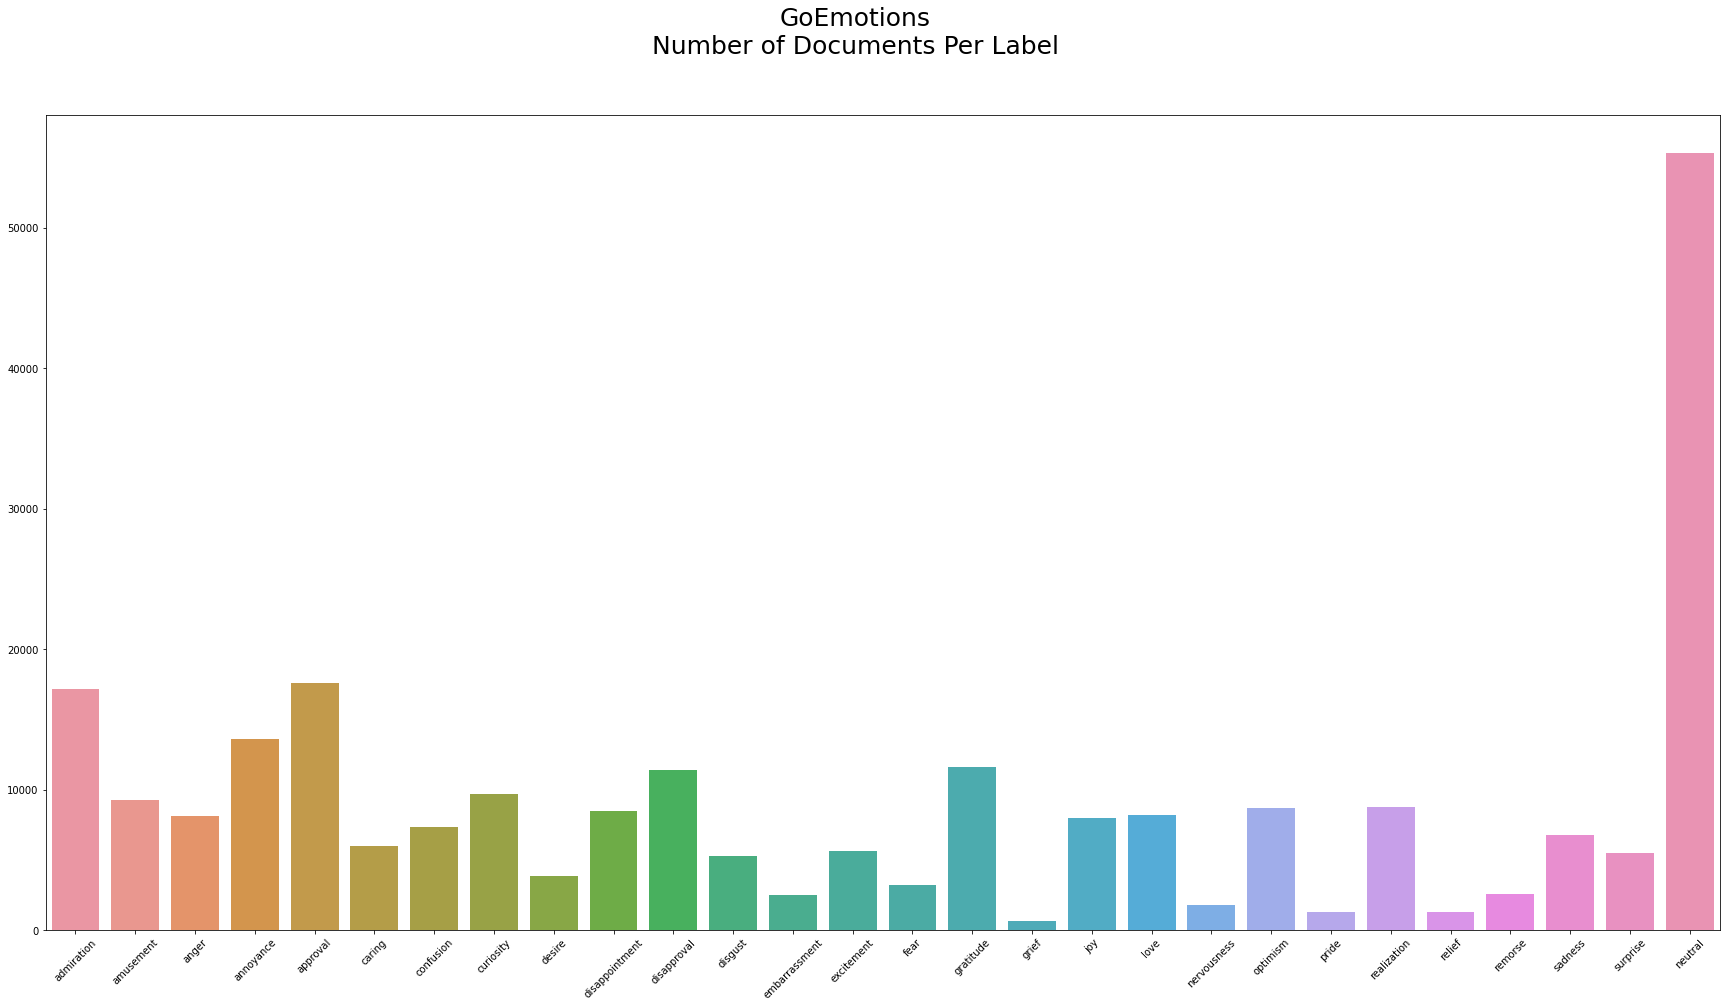

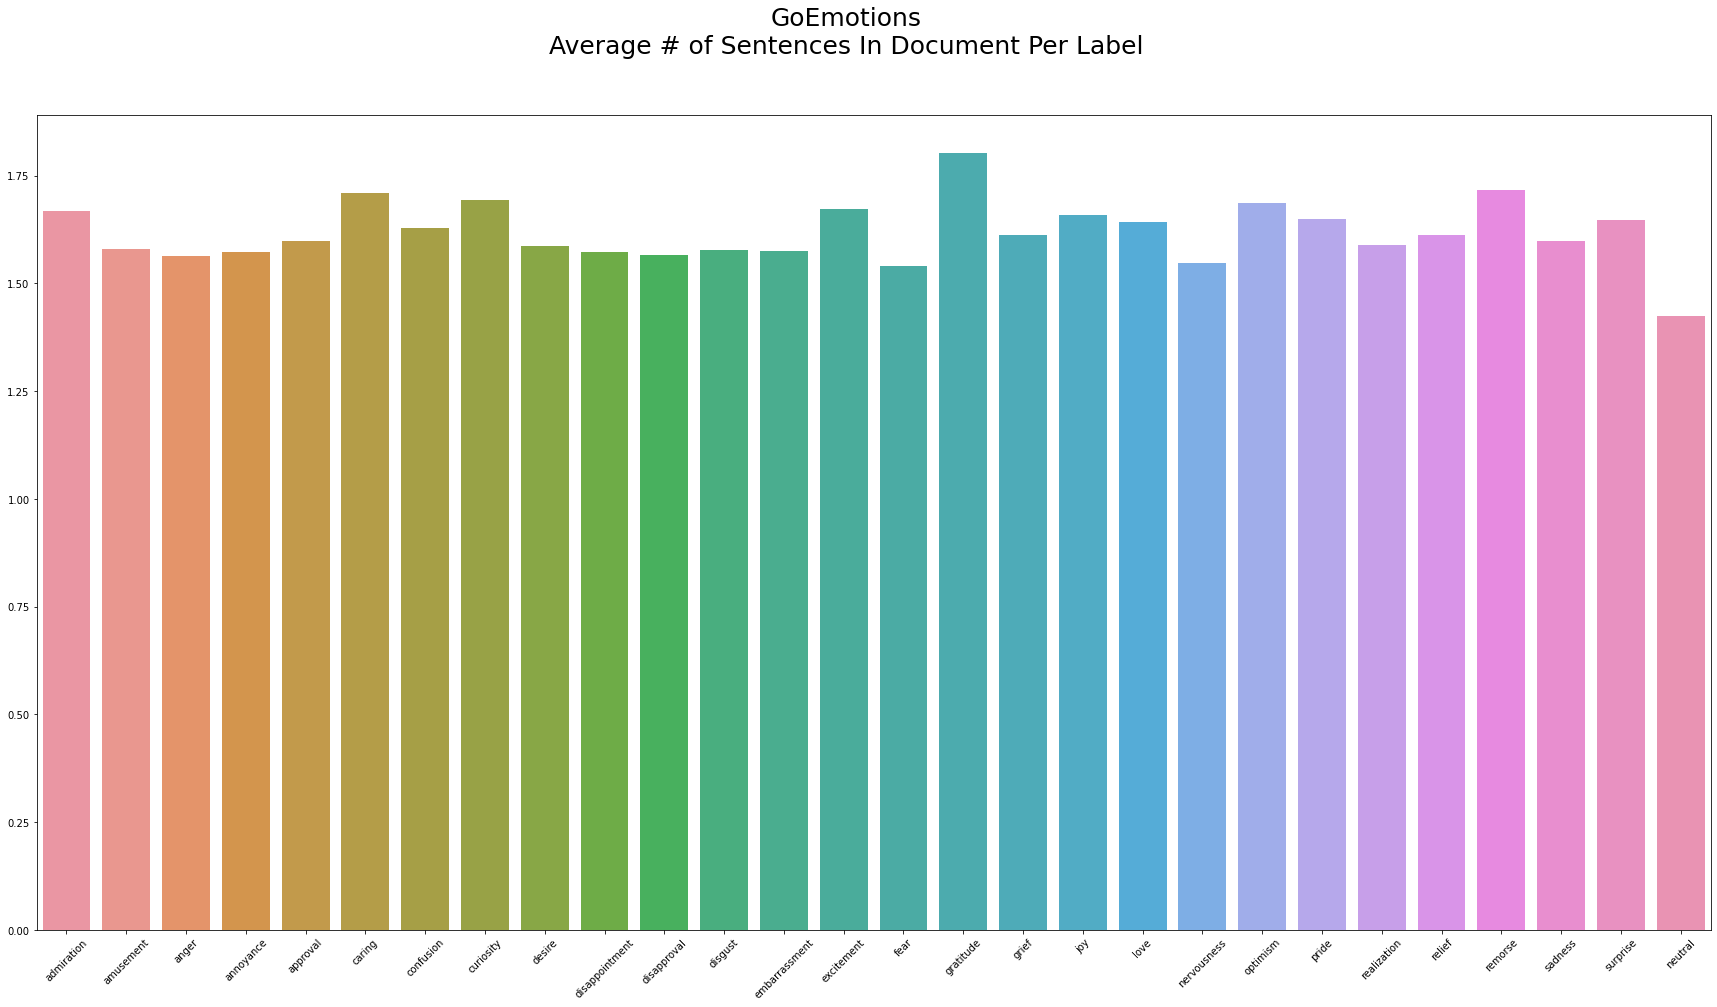

In [11]:
figure = plt.figure(figsize=(30, 15))
ax = figure.gca()
goemotions_samples_per_label = {emotion: goemotions_data[goemotions_data[emotion] == 1].shape[0] for emotion in goemotions_all_labels}
sns.barplot(x=goemotions_all_labels, y=list(goemotions_samples_per_label.values()))
ax.set_xticklabels(labels=goemotions_all_labels, rotation=45)
figure.suptitle("GoEmotions\nNumber of Documents Per Label", fontsize=25)
plt.savefig("plots/goemotions_num_documents_per_label.png")
figure = plt.figure(figsize=(30, 15))
ax = figure.gca()
sentence_counts = []
for label, total_documents in goemotions_samples_per_label.items():
    label_sentence_count = 0
    for _, row in goemotions_data.loc[goemotions_data[label] == 1].iterrows():
        label_sentence_count += len(sent_tokenize(row["text"]))
    sentence_counts.append(label_sentence_count)
average_sentences_per_label = np.array(sentence_counts) / np.array(list(goemotions_samples_per_label.values()))
sns.barplot(x=goemotions_all_labels, y=average_sentences_per_label)
ax.set_xticklabels(labels=goemotions_all_labels, rotation=45)
figure.suptitle("GoEmotions\nAverage # of Sentences In Document Per Label", fontsize=25)
plt.savefig("plots/goemotions_avg_sentences_in_document_per_label.png")

### Create & Train Model

In [12]:
model = tfs.TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(goemotions_all_labels), id2label={k: v for k, v in enumerate(goemotions_all_labels)}, label2id={v: k for k, v in enumerate(goemotions_all_labels)})
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=[tf.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)])
model.summary()

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it fo

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 65190912  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  21532     
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 65,803,036
Trainable params: 65,803,036
Non-trainable params: 0
_________________________________________________________________


In [13]:
if os.path.isdir(model_output_folder):
    print("Loading pretrained model")
    model = model.from_pretrained(model_output_folder)
else:
    print("Training model")
    model.fit(train_dataset, validation_data=eval_dataset, epochs=5)
    model.save_pretrained(model_output_folder)

Loading pretrained model


Some layers from the model checkpoint at model_outputs_distill were not used when initializing TFDistilBertForSequenceClassification: ['dropout_97']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at model_outputs_distill and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Performance Evaluation

In [14]:
if os.path.isfile(analysis_data_file_path):
    display("Loading analysis data...")
    with open(analysis_data_file_path, "rb") as in_file:
        analysis_data, confusion_matrices, labels, probabilities = dill.load(in_file)
else:
    display("Generating analysis data")
    # Remove the shuffling for the train and eval sets
    train_dataset = Dataset.from_dict(encoded_inputs["train"]).to_tf_dataset(
                columns=["attention_mask", "input_ids", "token_type_ids"],
                label_cols=["labels"],
                batch_size=128,
                shuffle=False,
                collate_fn=data_collator
                )
    eval_dataset = Dataset.from_dict(encoded_inputs["eval"]).to_tf_dataset(
                columns=["attention_mask", "input_ids", "token_type_ids"],
                label_cols=["labels"],
                batch_size=128,
                shuffle=False,
                collate_fn=data_collator
                )
    test_dataset = Dataset.from_dict(encoded_inputs["test"]).to_tf_dataset(
            columns=["attention_mask", "input_ids", "token_type_ids"],
            label_cols=["labels"],
            batch_size=128,
            shuffle=False,
            collate_fn=data_collator
            )      
    labels = []
    one_hot_labels = []
    probabilities = []
    predictions = []
    reports = []
    confusion_matrices = []
    for dataset_name, dataset in zip(dataset_aliases, [train_dataset, eval_dataset, test_dataset]):
        labels.append(encoded_inputs[dataset_name]["labels"])
        one_hot_labels.append(tf.one_hot(labels[-1], len(goemotions_all_labels), axis=1))
        probabilities.append(tf.keras.activations.softmax(tf.convert_to_tensor(np.array(model.predict(dataset)["logits"]))))
        predictions.append(tf.math.argmax(probabilities[-1], axis=-1))
        reports.append(classification_report(predictions[-1].numpy(), labels[-1].numpy(), output_dict=True))
        confusion_matrices.append(tf.math.confusion_matrix(labels[-1], predictions[-1]))
    analysis_data = pd.DataFrame()
    for dataset_alias, report in zip(dataset_aliases, reports):
        report_df = pd.DataFrame(report).transpose()
        report_df["dataset_alias"] = dataset_alias
        report_df["label"] = report_df.index
        report_df.replace({"label": goemotions_all_labels_dict}, inplace=True)
        analysis_data = pd.concat([analysis_data, report_df])
        analysis_data.reset_index(inplace=True, drop=True)
        analysis_data.head()
    with open(analysis_data_file_path, "wb") as out_file:
        dill.dump((analysis_data, confusion_matrices, labels, probabilities), out_file)

'Loading analysis data...'

/tmp/ipykernel_15754/3782510722.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)
/tmp/ipykernel_15754/3782510722.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)
/tmp/ipykernel_15754/3782510722.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)
/tmp/ipykernel_15754/3782510722.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)


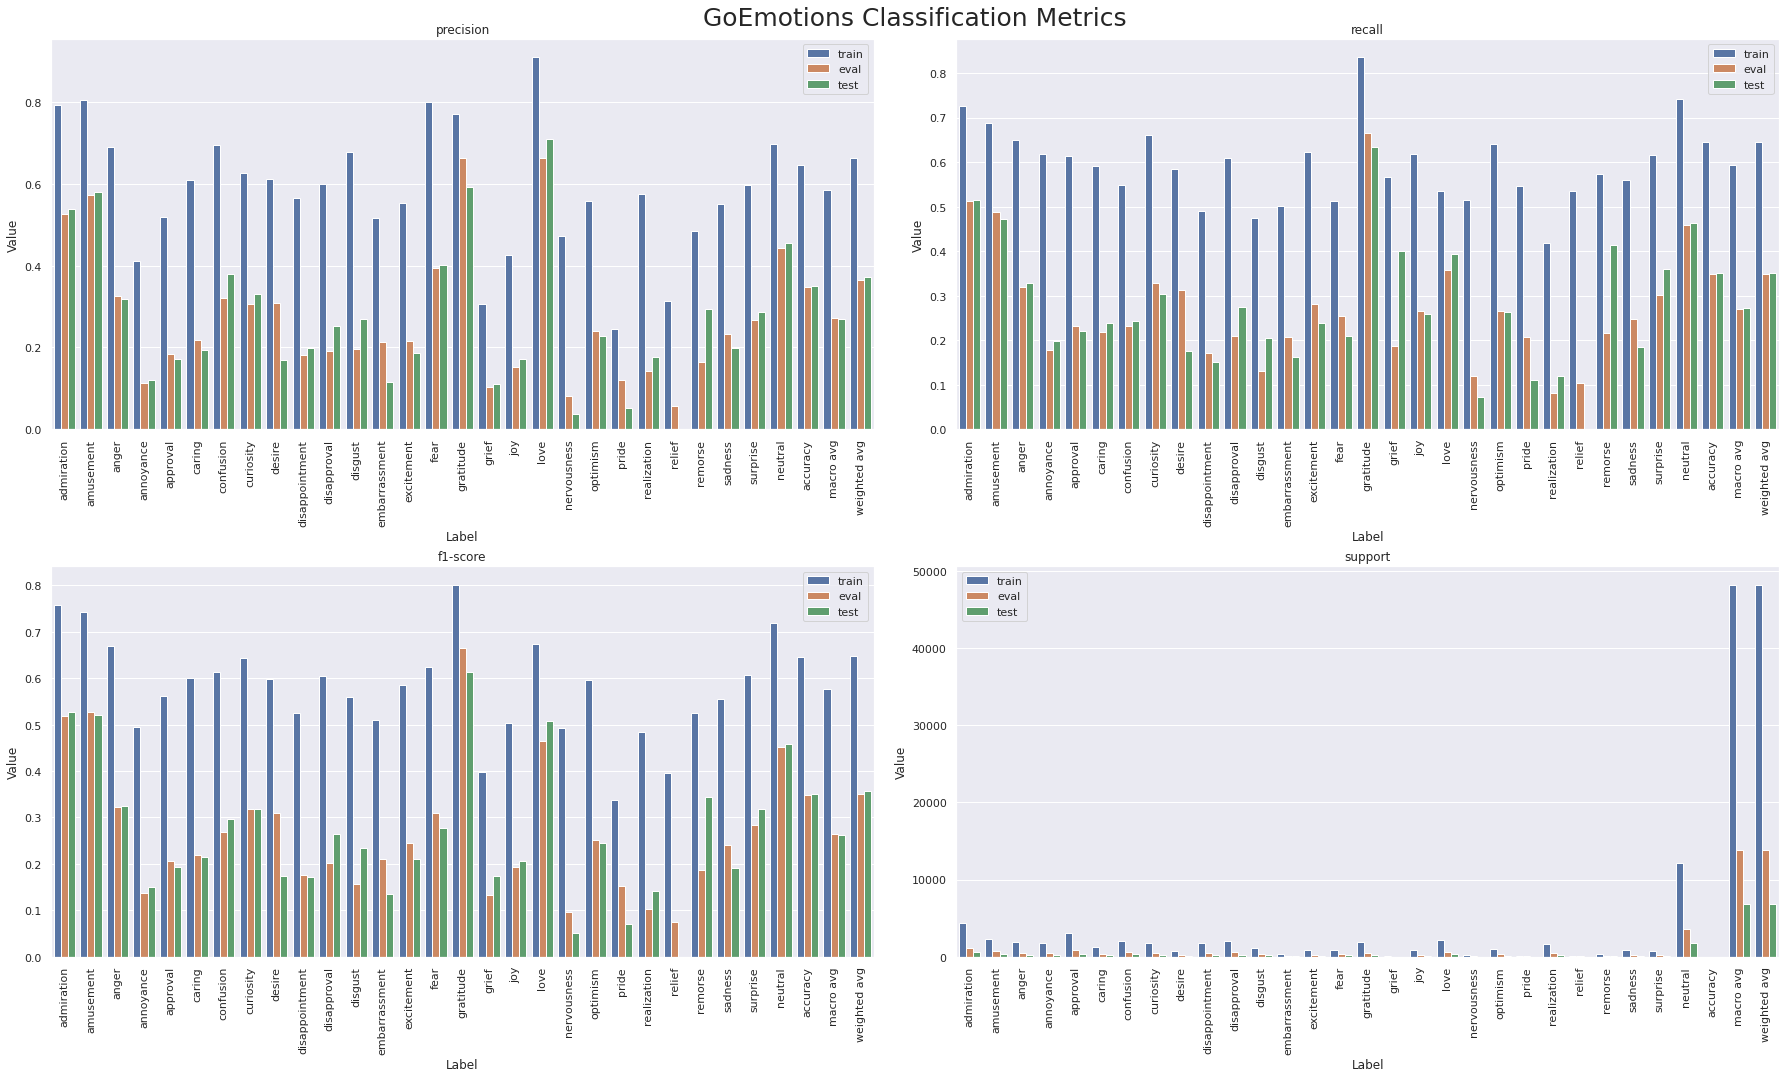

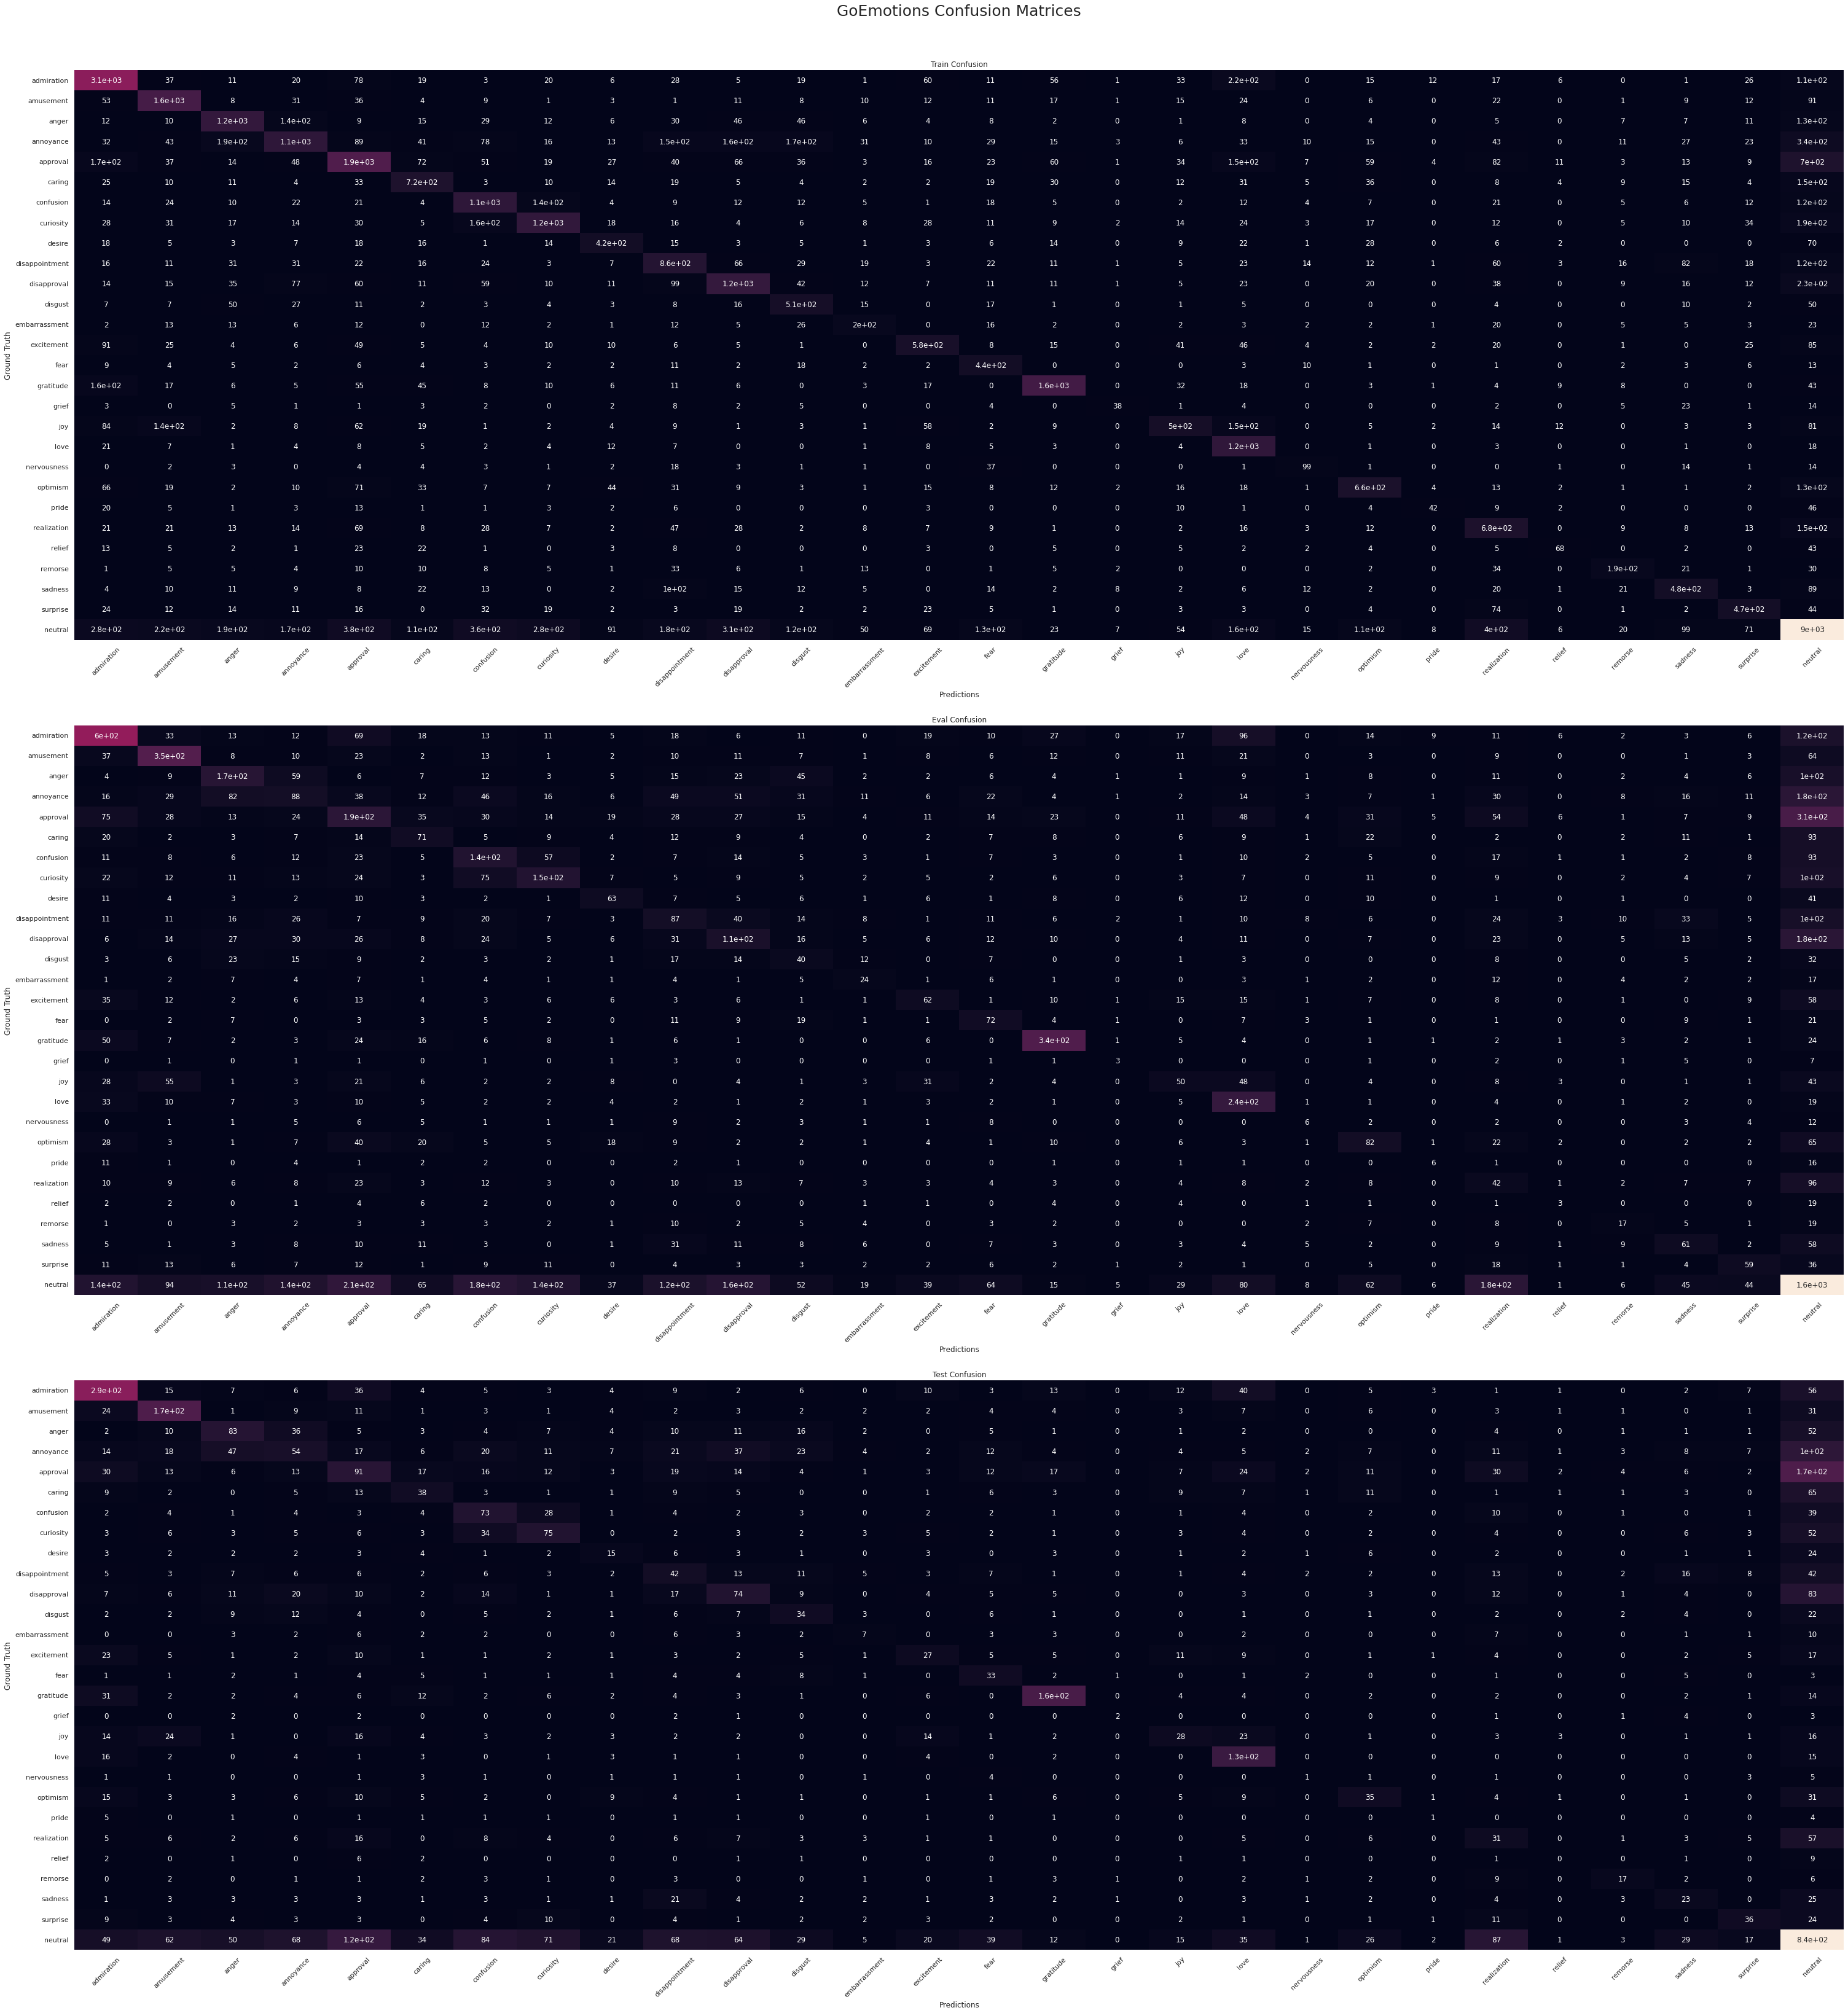

In [15]:
grouped_bar_plots = True
sns.set_style()
sns.set_theme()
plot_shape = (2 if grouped_bar_plots else 3, 2 if grouped_bar_plots else 4)
figure, axes = plt.subplots(plot_shape[0], plot_shape[1])
figure.set_size_inches(30, 15)
for i, dataset_alias in enumerate(dataset_aliases):
    for j, metric_name in enumerate(analysis_data.columns[:4]):
        flat_index = i * j + j
        unraveled_index = np.unravel_index([flat_index], plot_shape)
        ax = axes[unraveled_index[0][0], unraveled_index[1][0]]
        plt.axes(ax)
        ax.set_title(f"{dataset_alias[0].upper()}{dataset_alias[1:]}\n{metric_name}" if not grouped_bar_plots and j == 0 else metric_name)
        ax.set_xlabel("Label")
        ax.set_ylabel("Value")
        ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)
        if grouped_bar_plots:
            if i == 0:
                sns.barplot(x=analysis_data["label"].to_numpy(), y=analysis_data[metric_name].to_numpy(), hue=analysis_data["dataset_alias"].to_numpy(), ci="sd", capsize=0.05)
        else:
            sns.barplot(x="label", y=metric_name, data=analysis_data.loc[analysis_data["dataset_alias"] == dataset_alias], ax=ax, ci="sd", capsize=0.05)
    if grouped_bar_plots:
        break
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.35)
figure.suptitle("GoEmotions Classification Metrics", fontsize=25)
plt.savefig("plots/goemotions_classification_metrics.png")
figure, axes = plt.subplots(3, 1)
figure.set_size_inches(50, 50)
for i, dataset_alias in enumerate(dataset_aliases):
        ax = axes[i]
        plt.axes(ax)
        ax.set_title(f"{dataset_alias[0].upper()}{dataset_alias[1:]} Confusion")
        sns.heatmap(confusion_matrices[i], annot=True, cbar=False)
        ax.set_xlabel("Predictions")
        ax.set_ylabel("Ground Truth")
        ax.set_xticklabels(labels=goemotions_all_labels, rotation=45)
        ax.set_yticklabels(labels=goemotions_all_labels, rotation=0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.15)
figure.suptitle("GoEmotions Confusion Matrices", fontsize=25)
plt.savefig("plots/goemotions_confusion_matrices.png")

## Fake Or Real News

### Load & Preprocess The Dataset

In [16]:
true_data = pd.read_csv(os.path.join(news_dataset_folder, "True.csv"))
true_data["label"] = 1
fake_data = pd.read_csv(os.path.join(news_dataset_folder, "Fake.csv"))
fake_data["label"] = 0
news_data = pd.concat([true_data, fake_data])
is_space = news_data["text"].str.isspace()
news_data.drop(is_space.loc[is_space == True].index, inplace=True)
news_data = news_data.sample(frac=1).reset_index(drop=True) # Set frac = 1 to just shuffle the dataset

In [17]:
display(news_data.head())
display(news_data.shape)

title  \
0  Trump moving U.S. toward era of bilateral trad...   
1  Republican congressional candidate in Montana ...   
2   Conservative Megachurch Pastor Forced To Resi...   
3  Aide tries to refocus tax debate after Trump's...   
4   Obama Makes UNPRECEDENTED Move To Protect The...   

                                                text       subject  \
0  WASHINGTON (Reuters) - President Donald Trump ...  politicsNews   
1  (Reuters) - Montana Republican congressional c...  politicsNews   
2  Another conservative  Christian  hypocrite get...          News   
3  WASHINGTON (Reuters) - President Donald Trump’...  politicsNews   
4  President Barack Obama knows that President-el...          News   

                date  label  
0  January 23, 2017       1  
1      May 25, 2017       1  
2  February 12, 2016      0  
3  December 8, 2017       1  
4   December 6, 2016      0

(43652, 5)

### Extract Features

In [18]:
news_indices = list(range(news_data.shape[0]))
train_indices = news_indices[:int(train_data_percentage * news_data.shape[0])]
eval_indices = news_indices[len(train_indices):len(train_indices) + int(eval_data_percentage * news_data.shape[0])]
test_indices = news_indices[len(train_indices) + len(eval_indices):]
subject_encoder = OneHotEncoder() # We will use this later when analyzing articles so store it if its not needed in this celll
subject_encoder.fit(news_data["subject"].to_numpy().reshape(-1, 1))
if os.path.isfile(extracted_features_file_path):
    with open(extracted_features_file_path, "rb") as in_file:
        feats, labels = dill.load(in_file)
else:
    encoded_titles = data_collator(tokenizer(news_data["title"].to_list(), truncation=True))
    tokenized_sentences = []
    sentence_counts = []
    for _, row in news_data.iterrows():
        sentences = sent_tokenize(row["text"])
        sentence_counts.append(len(sentences))
        tokenized_sentences.extend(sentences)
    encoded_sentences = data_collator(tokenizer(tokenized_sentences, truncation=True))
    encoded_subject = subject_encoder.transform(news_data["subject"].to_numpy().reshape(-1, 1))
    titles_dataset = Dataset.from_dict(encoded_titles).to_tf_dataset(
                columns=["attention_mask", "input_ids", "token_type_ids"],
                label_cols=["labels"],
                batch_size=128,
                shuffle=False,
                collate_fn=data_collator
                )
    title_outputs = tf.convert_to_tensor(np.array(model.predict(titles_dataset)["logits"]))
    title_probabilities = tf.keras.activations.softmax(title_outputs)
    document_sentences_dataset = Dataset.from_dict(encoded_sentences).to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["labels"],
        batch_size=128,
        shuffle=False,
        collate_fn=data_collator
        )
    sentence_probabilities = tf.keras.activations.softmax(tf.convert_to_tensor(np.array(model.predict(document_sentences_dataset)["logits"])))
    text_predictions = []
    text_probabilities = []
    start_index = 0
    for i, sentence_count in enumerate(sentence_counts):
        document_sentence_probabilities = sentence_probabilities[start_index:start_index + sentence_count, :]
        start_index += sentence_count
        top_3_predictions = tf.math.reduce_sum(tf.squeeze(tf.one_hot(tf.nn.top_k(document_sentence_probabilities, 3).indices, tf.shape(document_sentence_probabilities)[1])), axis=0)
        text_predictions.append(tf.math.reduce_sum(top_3_predictions, axis=0) if top_3_predictions.shape[0] == 3 else top_3_predictions)
        text_probabilities.append(tf.math.reduce_sum(document_sentence_probabilities, axis=0))
    feats = np.concatenate([tf.concat([title_probabilities, text_predictions, text_probabilities], axis=1).numpy(), np.squeeze(np.asarray(encoded_subject.todense()))], axis=1)
    labels = news_data["label"].to_numpy()
    with open(extracted_features_file_path, "wb") as out_file:
        dill.dump((feats, labels), out_file)

In [19]:
train_feats = feats[train_indices, :]
train_labels = labels[train_indices]
eval_feats = feats[eval_indices, :]
eval_labels = labels[eval_indices]
test_feats = feats[test_indices, :]
test_labels = labels[test_indices]

### Data Analysis

/home/octalbits/.conda/envs/nlp-course/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


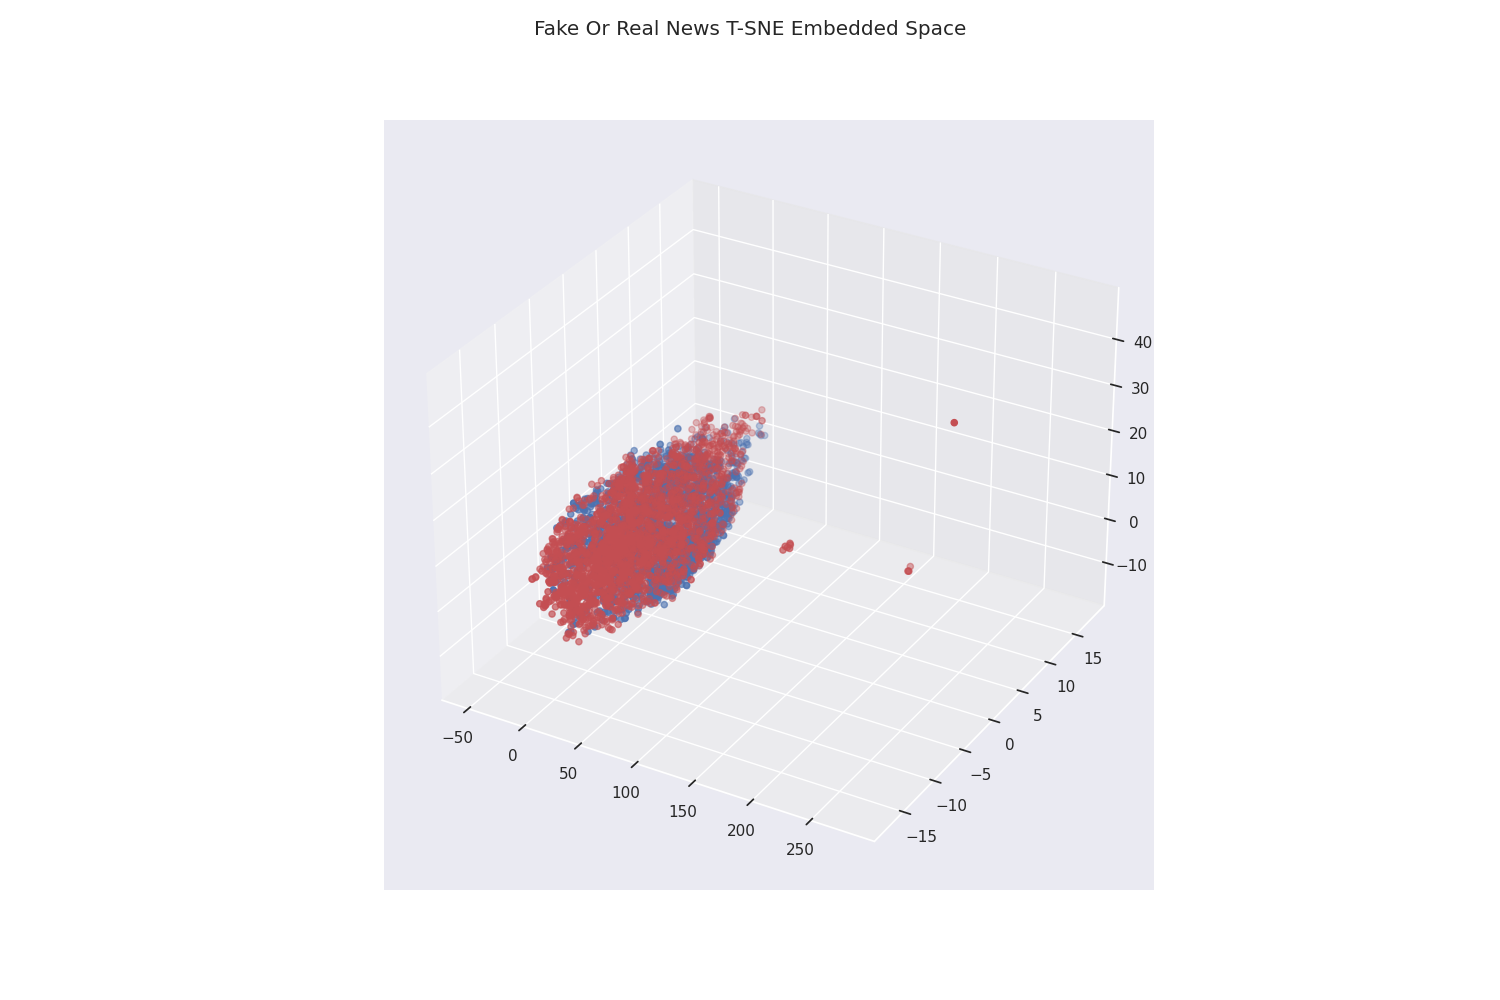

In [20]:
%matplotlib ipympl
tsne = TSNE(n_components=3, perplexity=30, early_exaggeration=2, n_iter_without_progress=10, learning_rate="auto", init="pca")
embedded_features = tsne.fit_transform(test_feats) # ideally we would run on full features, but to reduce processing time lets just use the test set 
sns.set_theme()
sns.set_style()
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')
true_indices = (test_labels == 1).nonzero()[0]
false_indices = (test_labels == 0).nonzero()[0]
for indices, color in zip([false_indices, true_indices], ["r", "b"]):
    ax.scatter(embedded_features[indices, 0], embedded_features[indices, 1], embedded_features[indices, 2],c=color)
fig.suptitle("Fake Or Real News T-SNE Embedded Space")
plt.savefig("plots/fake_or_real_news_TSNE.png")

In [21]:
title_probs_column_names = [f"title_probability_{emotion}" for emotion in goemotions_all_labels]
text_preds_column_names = [f"text_top_3_prediction_{emotion}" for emotion in goemotions_all_labels]
text_probs_column_names = [f"text_top_3_prediction_{emotion}" for emotion in goemotions_all_labels]
subject_names = news_data["subject"].to_numpy().reshape(-1, 1)
subject_encoder_order = subject_names[np.sort(np.unique(subject_names, return_index=True)[1])]
subject_encoder_column_names = subject_encoder_order[np.argsort(np.where(subject_encoder.transform(subject_encoder_order).todense())[1])]
column_names = title_probs_column_names
column_names.extend(text_preds_column_names)
column_names.extend(text_probs_column_names)
column_names.extend([element[0] for element in subject_encoder_column_names.tolist()])
column_names.append("label")
correlation_data = np.concatenate([feats, labels.reshape(-1, 1)], axis=1, dtype=np.float32)
correlation_data = pd.DataFrame(correlation_data, columns=column_names)

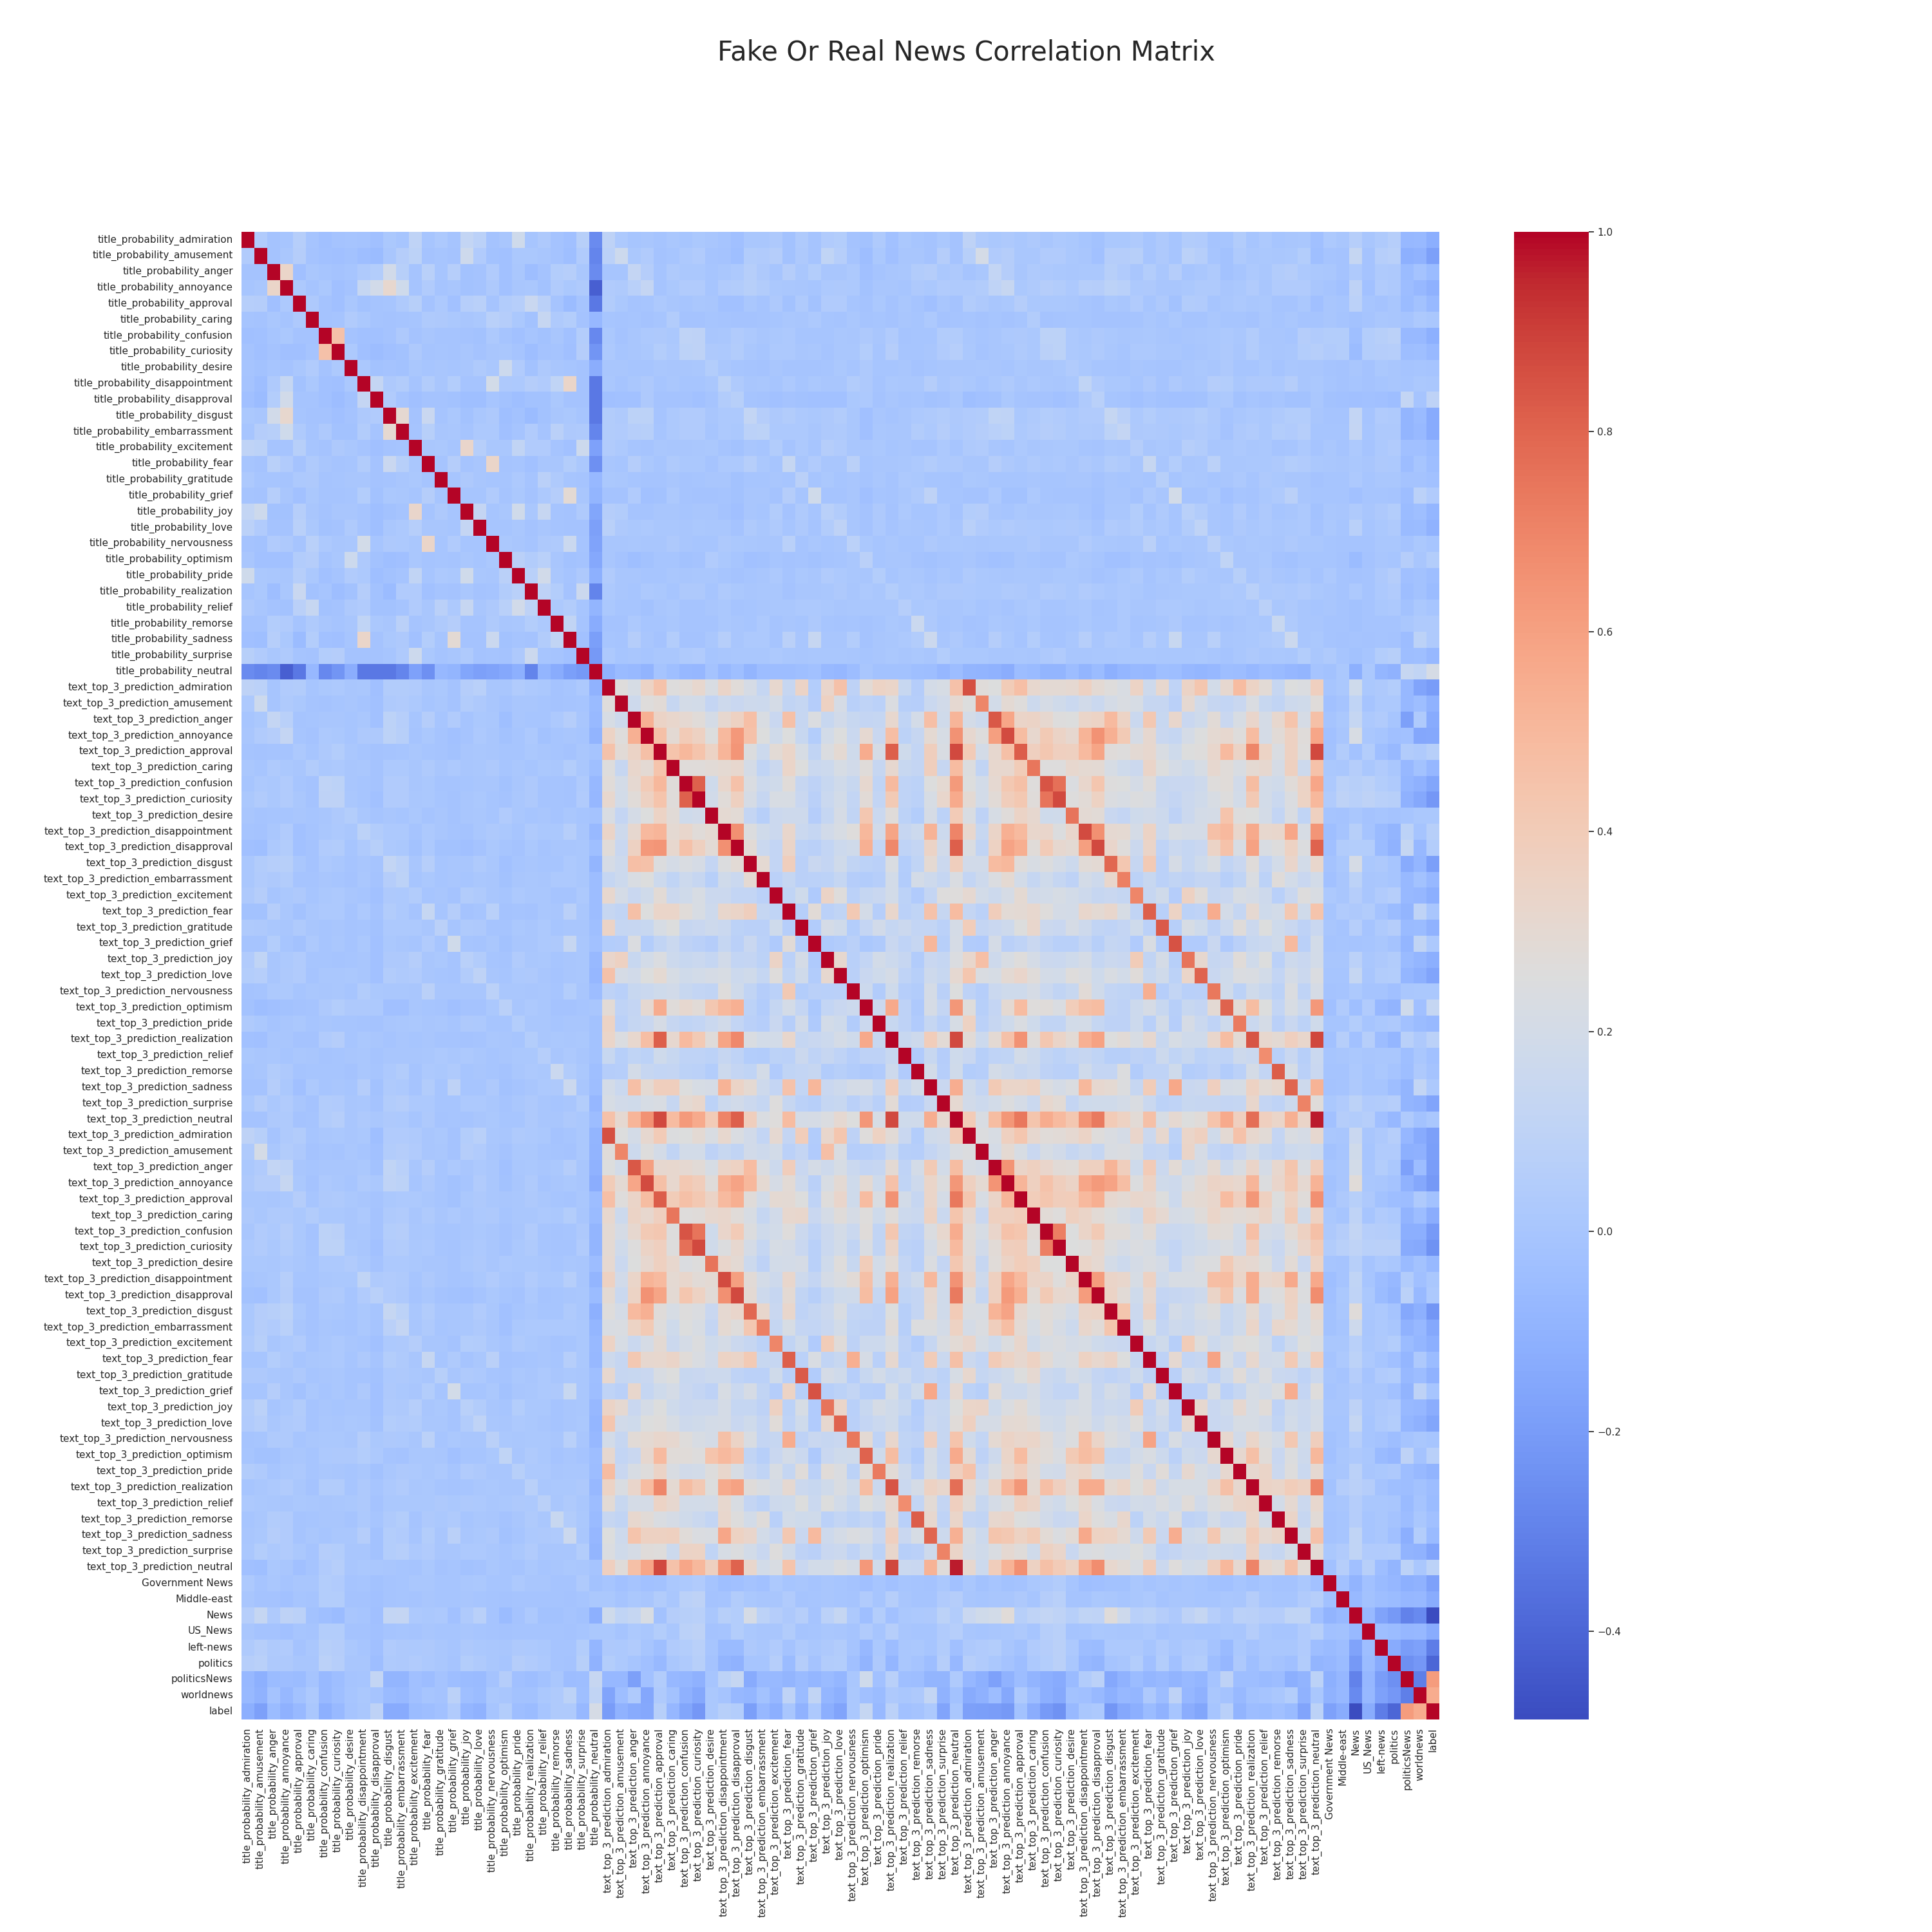

In [22]:
%matplotlib ipympl
figure = plt.figure(figsize=(30, 30))
sns.heatmap(correlation_data.corr(), fmt='.2g',cmap= 'coolwarm')
figure.suptitle("Fake Or Real News Correlation Matrix", fontsize=30)
plt.savefig("plots/fake_or_real_news_correlation.png")

There is a lot to unpack here

### Create & Train Model

In [23]:
news_model = SVC()
news_model.fit(train_feats, train_labels)

SVC()

### Performance Evaluation

In [24]:
train_predictions = news_model.predict(train_feats)
eval_predictions = news_model.predict(eval_feats)
test_predictions = news_model.predict(test_feats)
print(accuracy_score(train_labels, train_predictions), accuracy_score(eval_labels, eval_predictions), accuracy_score(test_labels, test_predictions))

0.9982327529781385 0.9986254295532646 0.9977095739807604


/tmp/ipykernel_15754/3604311229.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)
/tmp/ipykernel_15754/3604311229.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)
/tmp/ipykernel_15754/3604311229.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)
/tmp/ipykernel_15754/3604311229.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)


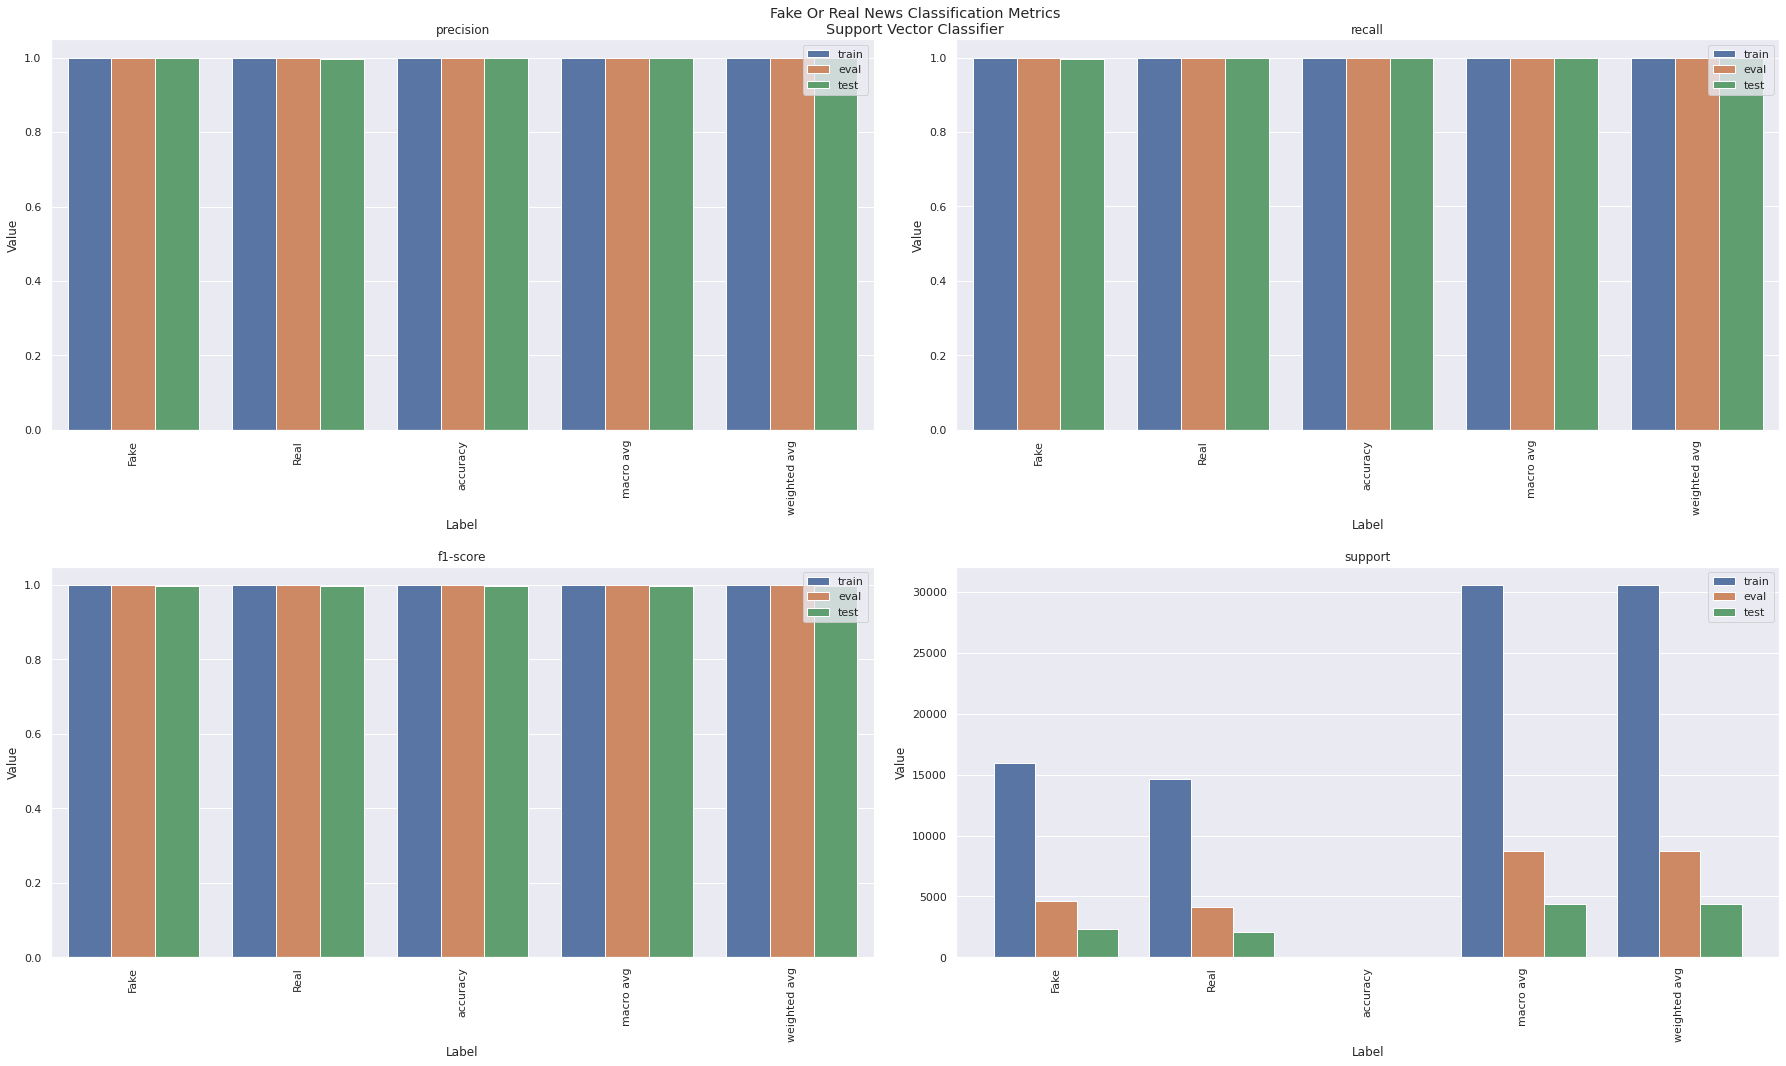

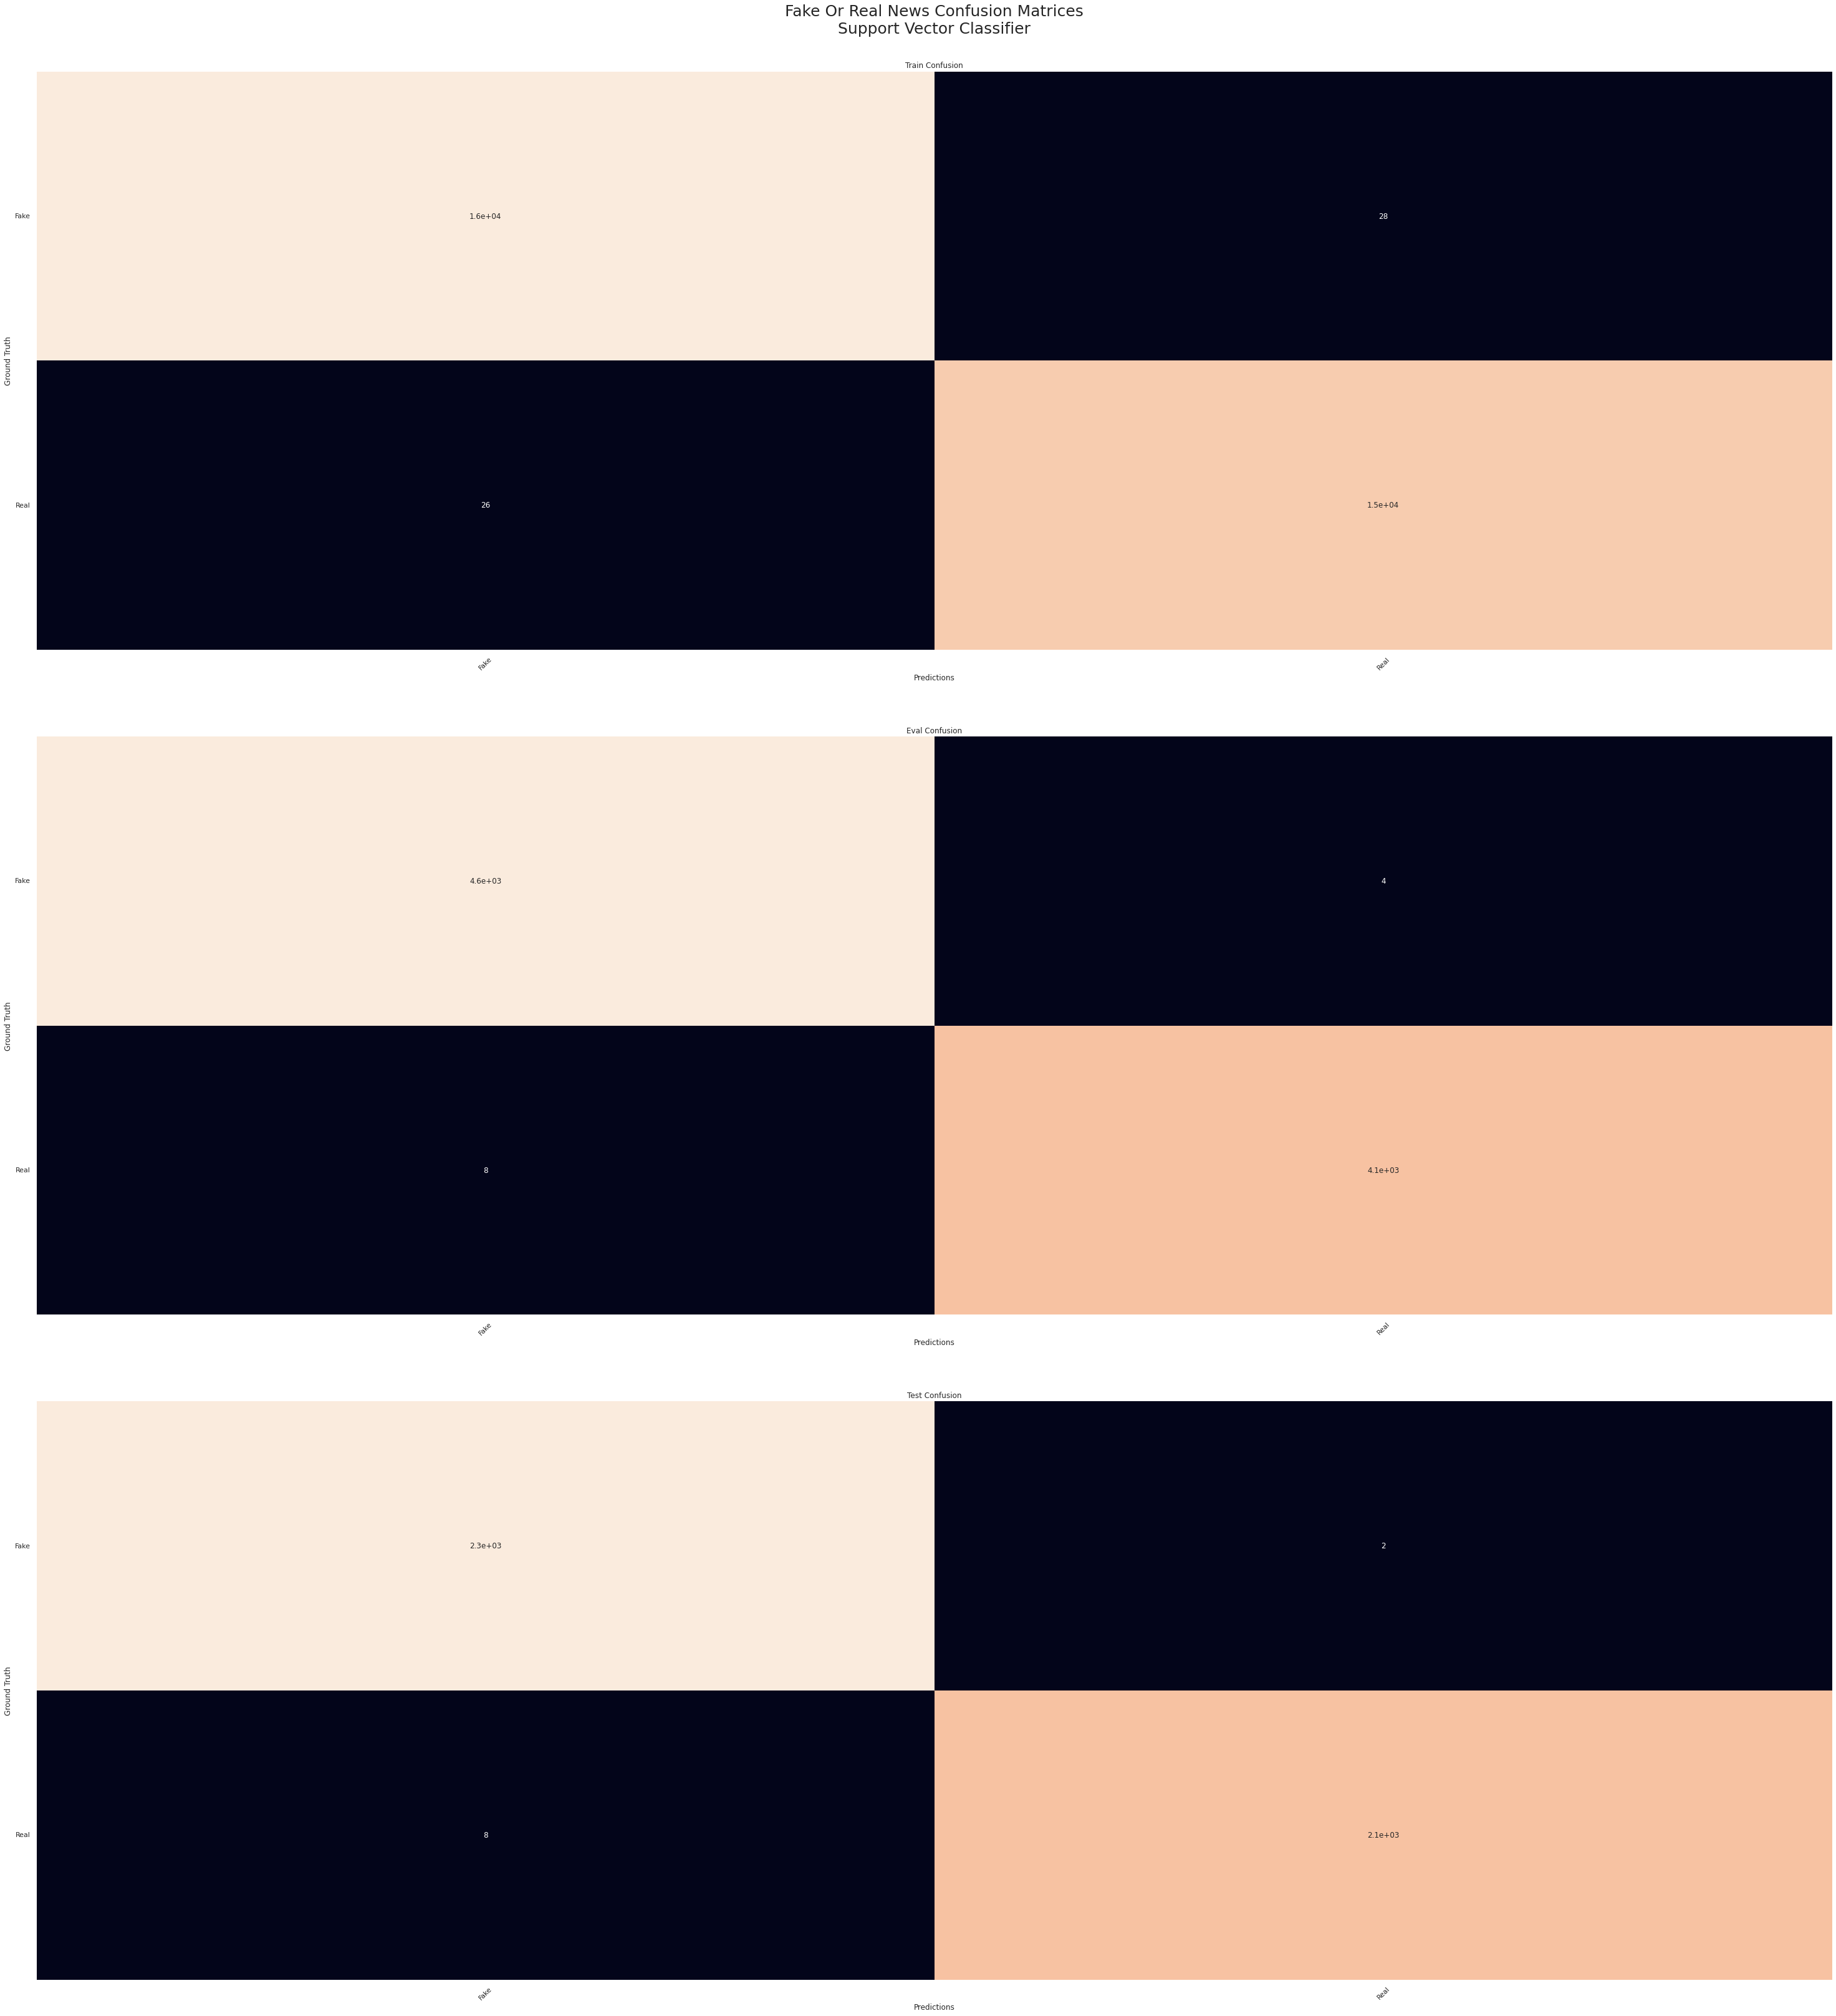

In [25]:
%matplotlib inline
analysis_data = pd.DataFrame()
confusion_matrices = []
for dataset_alias, (dataset_predictions, dataset_labels) in zip(dataset_aliases, zip([train_predictions, eval_predictions, test_predictions], [train_labels, eval_labels, test_labels])):
    report_df = pd.DataFrame(classification_report(dataset_predictions, dataset_labels, output_dict=True)).transpose()
    report_df["dataset_alias"] = dataset_alias
    report_df["label"] = report_df.index
    report_df.replace({"label": {"0": "Fake", "1": "Real"}}, inplace=True)
    analysis_data = pd.concat([analysis_data, report_df])
    confusion_matrices.append(confusion_matrix(dataset_labels, dataset_predictions))
analysis_data.reset_index(inplace=True, drop=True)
analysis_data.head()

grouped_bar_plots = True
sns.set_style()
sns.set_theme()
plot_shape = (2, 2 if grouped_bar_plots else 4)
figure, axes = plt.subplots(plot_shape[0], plot_shape[1])
figure.set_size_inches(30, 15)
for i, dataset_alias in enumerate(dataset_aliases):
    for j, metric_name in enumerate(analysis_data.columns[:4]):
        flat_index = i * j + j
        unraveled_index = np.unravel_index([flat_index], plot_shape)
        ax = axes[unraveled_index[0][0], unraveled_index[1][0]]
        plt.axes(ax)
        ax.set_title(f"{dataset_alias[0].upper()}{dataset_alias[1:]}\n{metric_name}" if not grouped_bar_plots and j == 0 else metric_name)
        ax.set_xlabel("Label")
        ax.set_ylabel("Value")
        ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)
        if grouped_bar_plots:
            if i == 0:
                sns.barplot(x=analysis_data["label"].to_numpy(), y=analysis_data[metric_name].to_numpy(), hue=analysis_data["dataset_alias"].to_numpy(), ci="sd", capsize=0.05)
        else:
            sns.barplot(x="label", y=metric_name, data=analysis_data.loc[analysis_data["dataset_alias"] == dataset_alias], ax=ax, ci="sd", capsize=0.05)
    if grouped_bar_plots:
        break
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.35)
figure.suptitle("Fake Or Real News Classification Metrics\nSupport Vector Classifier")
plt.savefig("plots/fake_or_real_news_classification_metrics.png")
plt.plot()
figure, axes = plt.subplots(3, 1)
figure.set_size_inches(50, 50)
for i, dataset_alias in enumerate(dataset_aliases):
        ax = axes[i]
        plt.axes(ax)
        ax.set_title(f"{dataset_alias[0].upper()}{dataset_alias[1:]} Confusion")
        sns.heatmap(confusion_matrices[i], annot=True, cbar=False)
        ax.set_xlabel("Predictions")
        ax.set_ylabel("Ground Truth")
        ax.set_xticklabels(labels=["Fake", "Real"], rotation=45)
        ax.set_yticklabels(labels=["Fake", "Real"], rotation=0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.15)
figure.suptitle("Fake Or Real News Confusion Matrices\nSupport Vector Classifier", fontsize=25)
plt.savefig("plots/fake_or_real_news_confusion_matrices.png")

### Results are phenomenal. 

![too_good](https://i.imgflip.com/ia8in.jpg)

#### Looking back at our correlation matrix we see a strong correlation when including the subject, this is a bias in our dataset. 
#### How do we do when we remove the subject from the features

In [26]:
unique_subject_len = subject_names[np.sort(np.unique(subject_names, return_index=True)[1])].size
xsubject_train_feats = train_feats[:, :-unique_subject_len]
xsubject_eval_feats = eval_feats[:, :-unique_subject_len]
xsubject_test_feats = test_feats[:, :-unique_subject_len]
news_model = SVC()
news_model.fit(xsubject_train_feats, train_labels)
train_predictions = news_model.predict(xsubject_train_feats)
eval_predictions = news_model.predict(xsubject_eval_feats)
test_predictions = news_model.predict(xsubject_test_feats)
print(accuracy_score(train_labels, train_predictions), accuracy_score(eval_labels, eval_predictions), accuracy_score(test_labels, test_predictions))

0.7929702840685954 0.7940435280641466 0.7796610169491526


### That seems more reasonable, now lets see if we can improve upon this score

In [27]:
def get_ratio_feats(feats: np.ndarray) -> np.ndarray:
    ratio_feats = np.copy(feats)
    feats_slice = feats[:, len(goemotions_all_labels):2*len(goemotions_all_labels)] # text top 3 predictions
    ratio_feats[:, len(goemotions_all_labels):2*len(goemotions_all_labels)] = np.divide(feats_slice, (np.sum(feats_slice, axis=1) / 3).reshape(-1, 1))
    feats_slice = feats[:, 2*len(goemotions_all_labels):3*len(goemotions_all_labels)] # text summed probabilities
    ratio_feats[:, 2*len(goemotions_all_labels):3*len(goemotions_all_labels)] = np.divide(feats_slice, (np.sum(feats_slice, axis=1)).reshape(-1, 1))
    assert feats.shape == ratio_feats.shape
    return ratio_feats

ratio_train_feats = get_ratio_feats(xsubject_train_feats)
ratio_eval_feats = get_ratio_feats(xsubject_eval_feats)
ratio_test_feats = get_ratio_feats(xsubject_test_feats)
news_model = Pipeline([("scaler", StandardScaler()), ("classifier", HistGradientBoostingClassifier(max_iter=5000, max_leaf_nodes=50, l2_regularization=1e-3))])
news_model.fit(ratio_train_feats, train_labels)
train_predictions = news_model.predict(ratio_train_feats)
eval_predictions = news_model.predict(ratio_eval_feats)
test_predictions = news_model.predict(ratio_test_feats)
print(accuracy_score(train_labels, train_predictions), accuracy_score(eval_labels, eval_predictions), accuracy_score(test_labels, test_predictions))

0.9892656106820265 0.8998854524627721 0.8905176362803482


### Some pretty good results lets replot the T-SNE embedding & correlation matrix with these updated features

/home/octalbits/.conda/envs/nlp-course/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


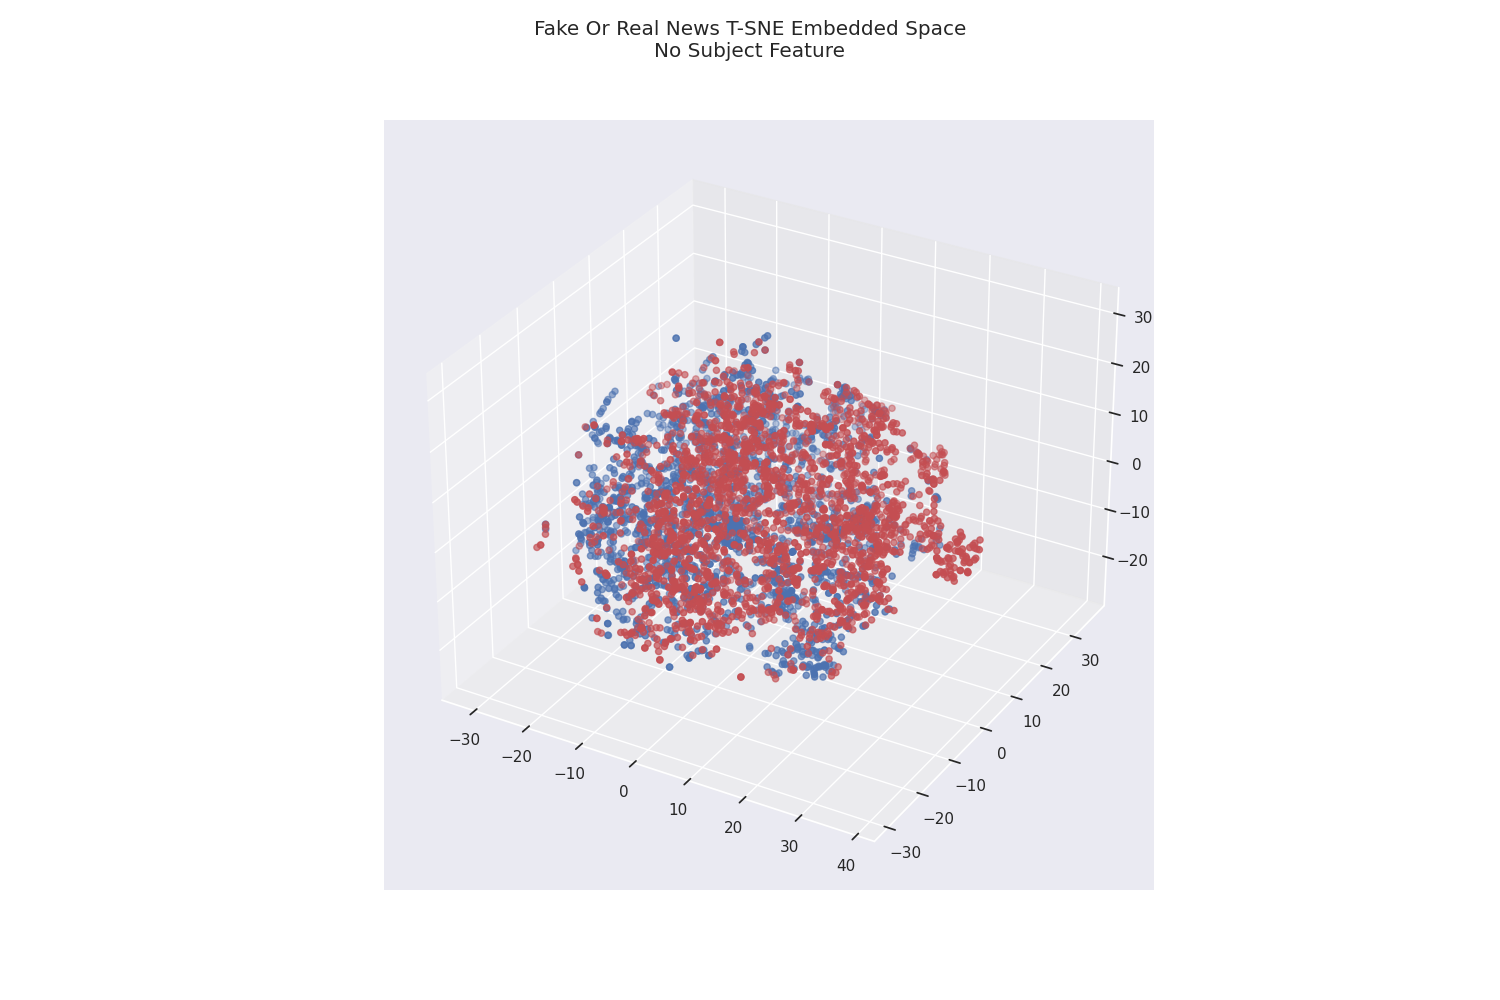

In [28]:
%matplotlib ipympl
tsne = TSNE(n_components=3, perplexity=10, early_exaggeration=12, n_iter_without_progress=50, learning_rate="auto", init="pca")
embedded_features = tsne.fit_transform(ratio_test_feats) # ideally we would run on full features, but to reduce processing time lets just use the test set 
sns.set_theme()
sns.set_style()
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')
true_indices = (test_labels == 1).nonzero()[0]
false_indices = (test_labels == 0).nonzero()[0]
for indices, color in zip([false_indices, true_indices], ["r", "b"]):
    ax.scatter(embedded_features[indices, 0], embedded_features[indices, 1], embedded_features[indices, 2],c=color)
fig.suptitle("Fake Or Real News T-SNE Embedded Space\nNo Subject Feature")
plt.savefig("plots/fake_or_real_news_TSNE_xsubject.png")

In [29]:
correlation_data = np.concatenate([np.concatenate([ratio_train_feats, ratio_eval_feats, ratio_test_feats], axis=0), labels.reshape(-1, 1)], axis=1, dtype=np.float32)
xsubject_column_names = column_names[:3*len(goemotions_all_labels)]
xsubject_column_names.append("label")
correlation_data = pd.DataFrame(correlation_data, columns=xsubject_column_names)

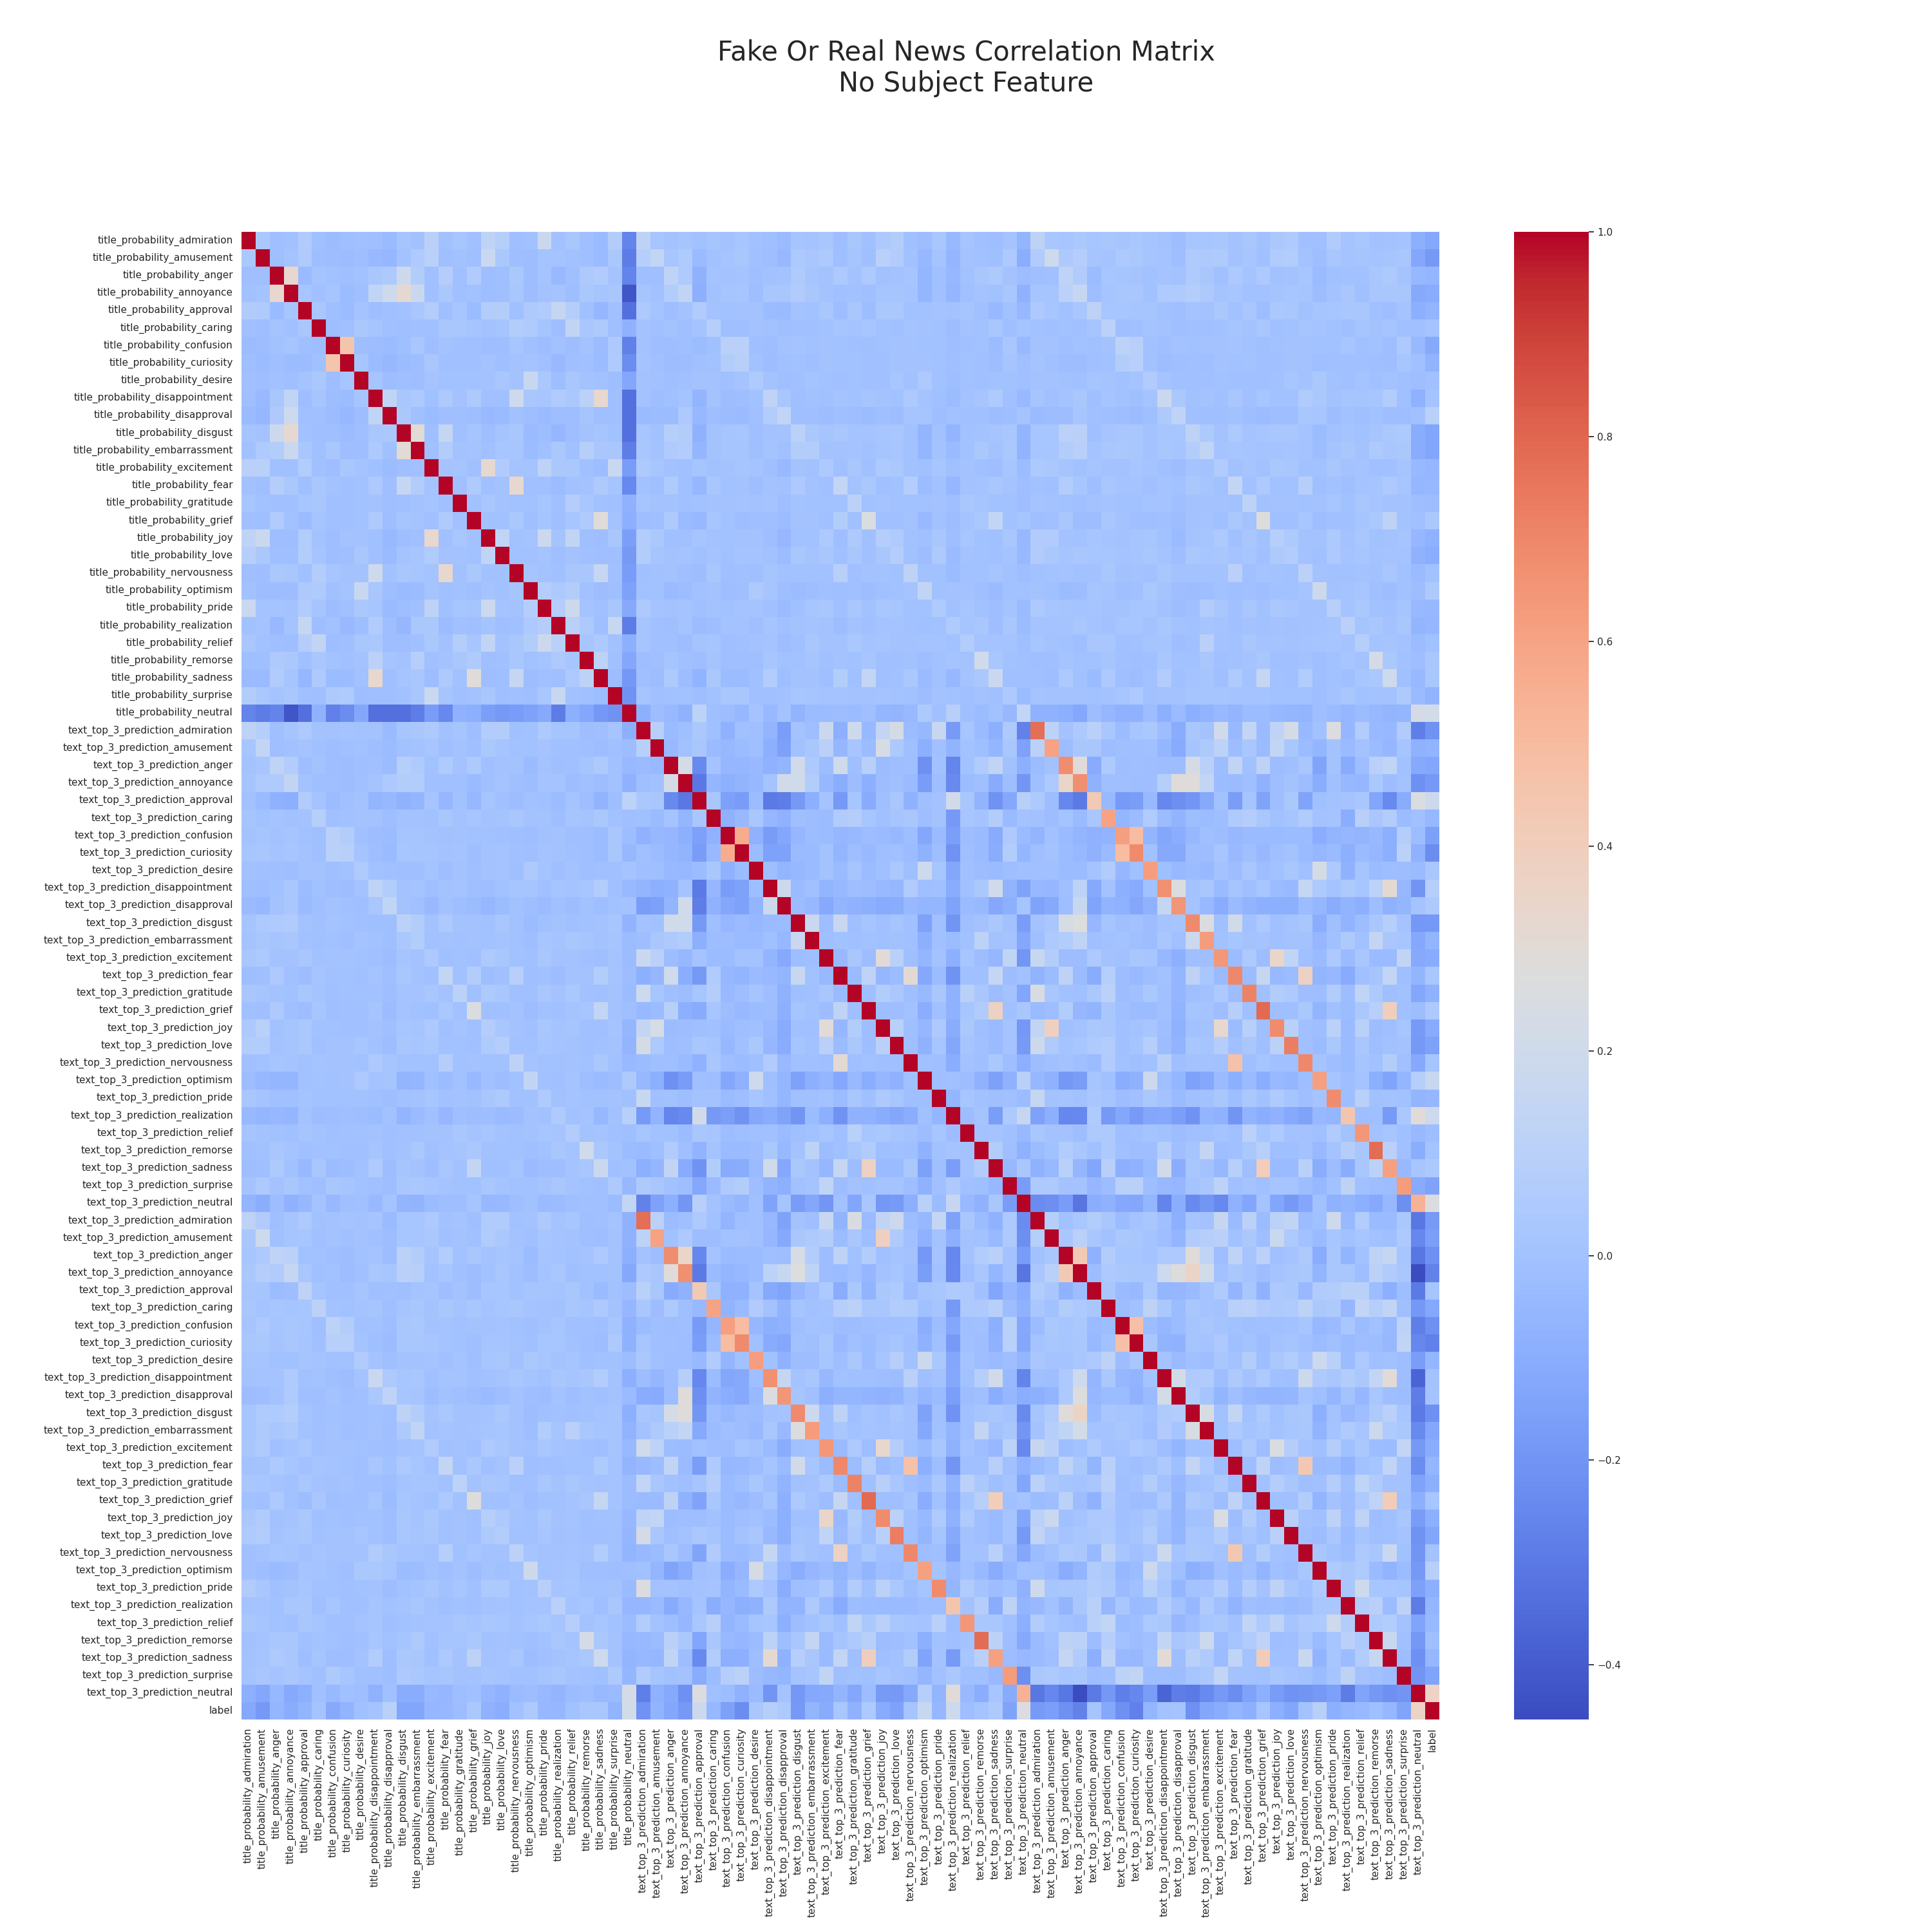

In [30]:
figure = plt.figure(figsize=(30, 30))
sns.heatmap(correlation_data.corr(), fmt='.2g',cmap= 'coolwarm')
figure.suptitle("Fake Or Real News Correlation Matrix\nNo Subject Feature", fontsize=30)
plt.savefig("plots/fake_or_real_news_correlation_xsubject.png")

/tmp/ipykernel_15754/733659630.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)
/tmp/ipykernel_15754/733659630.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)
/tmp/ipykernel_15754/733659630.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)
/tmp/ipykernel_15754/733659630.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)


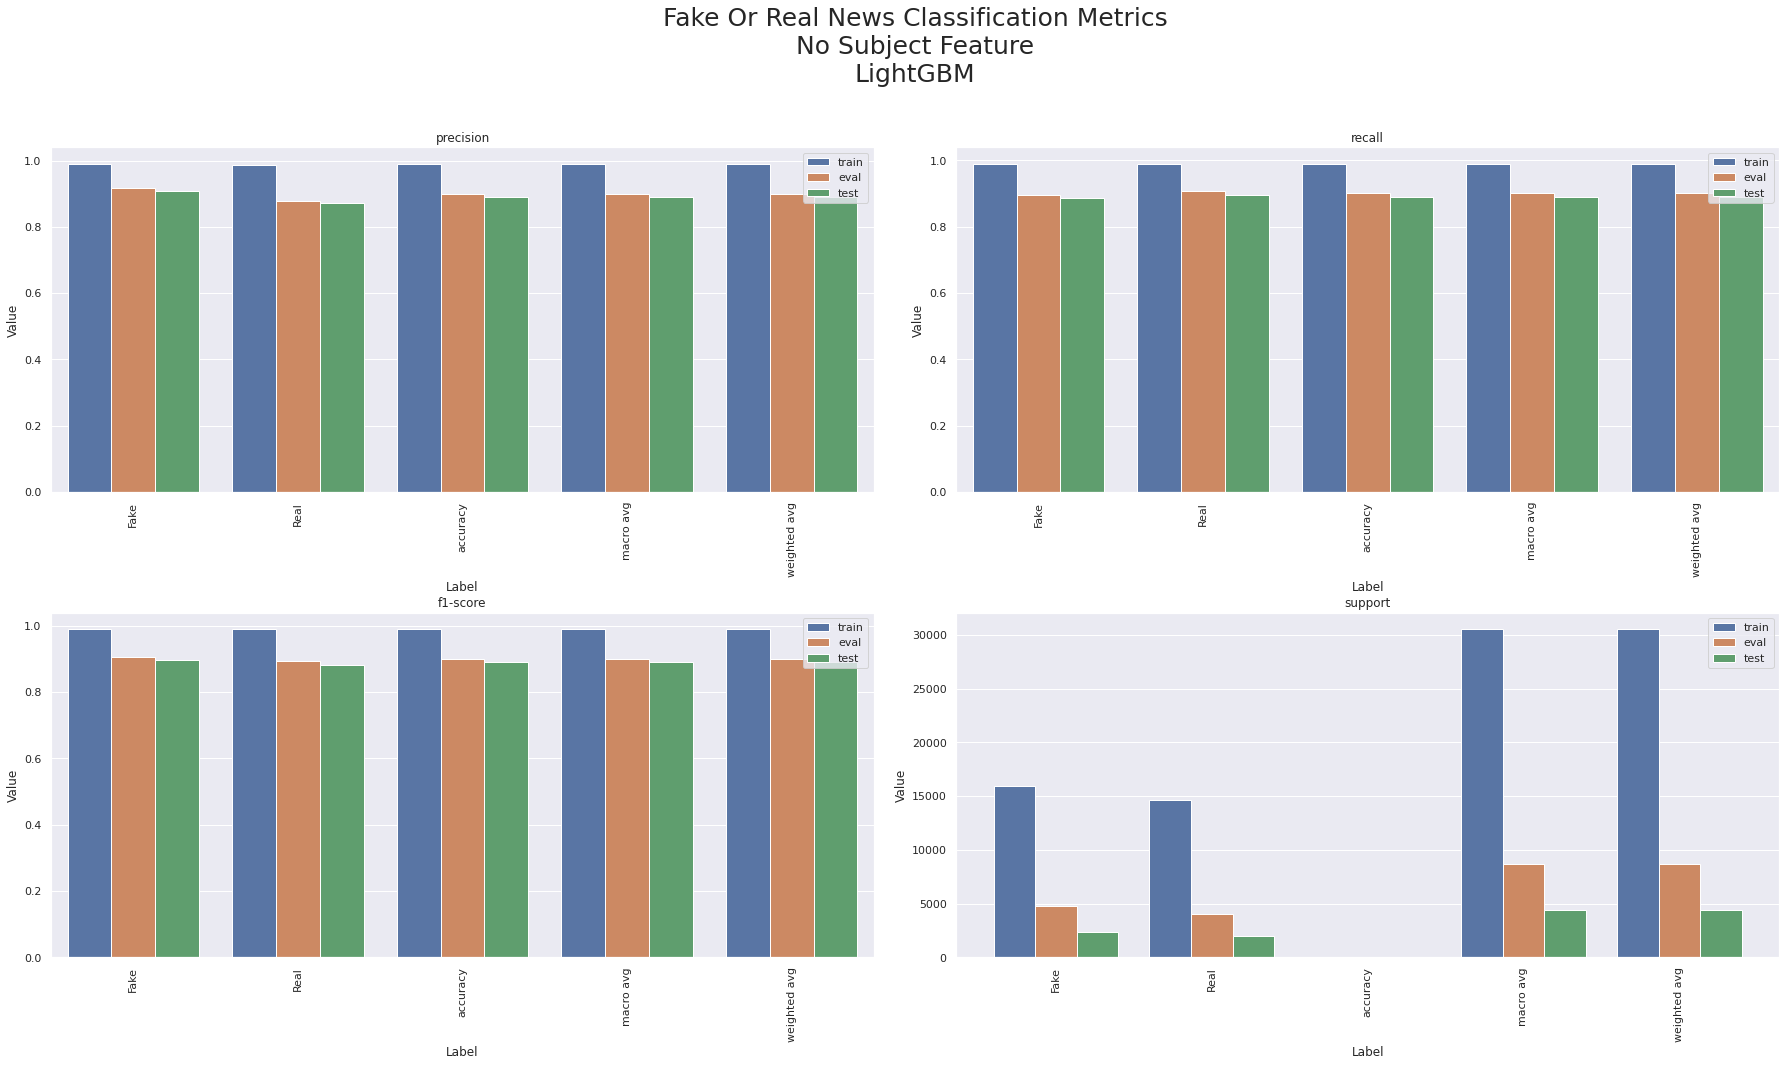

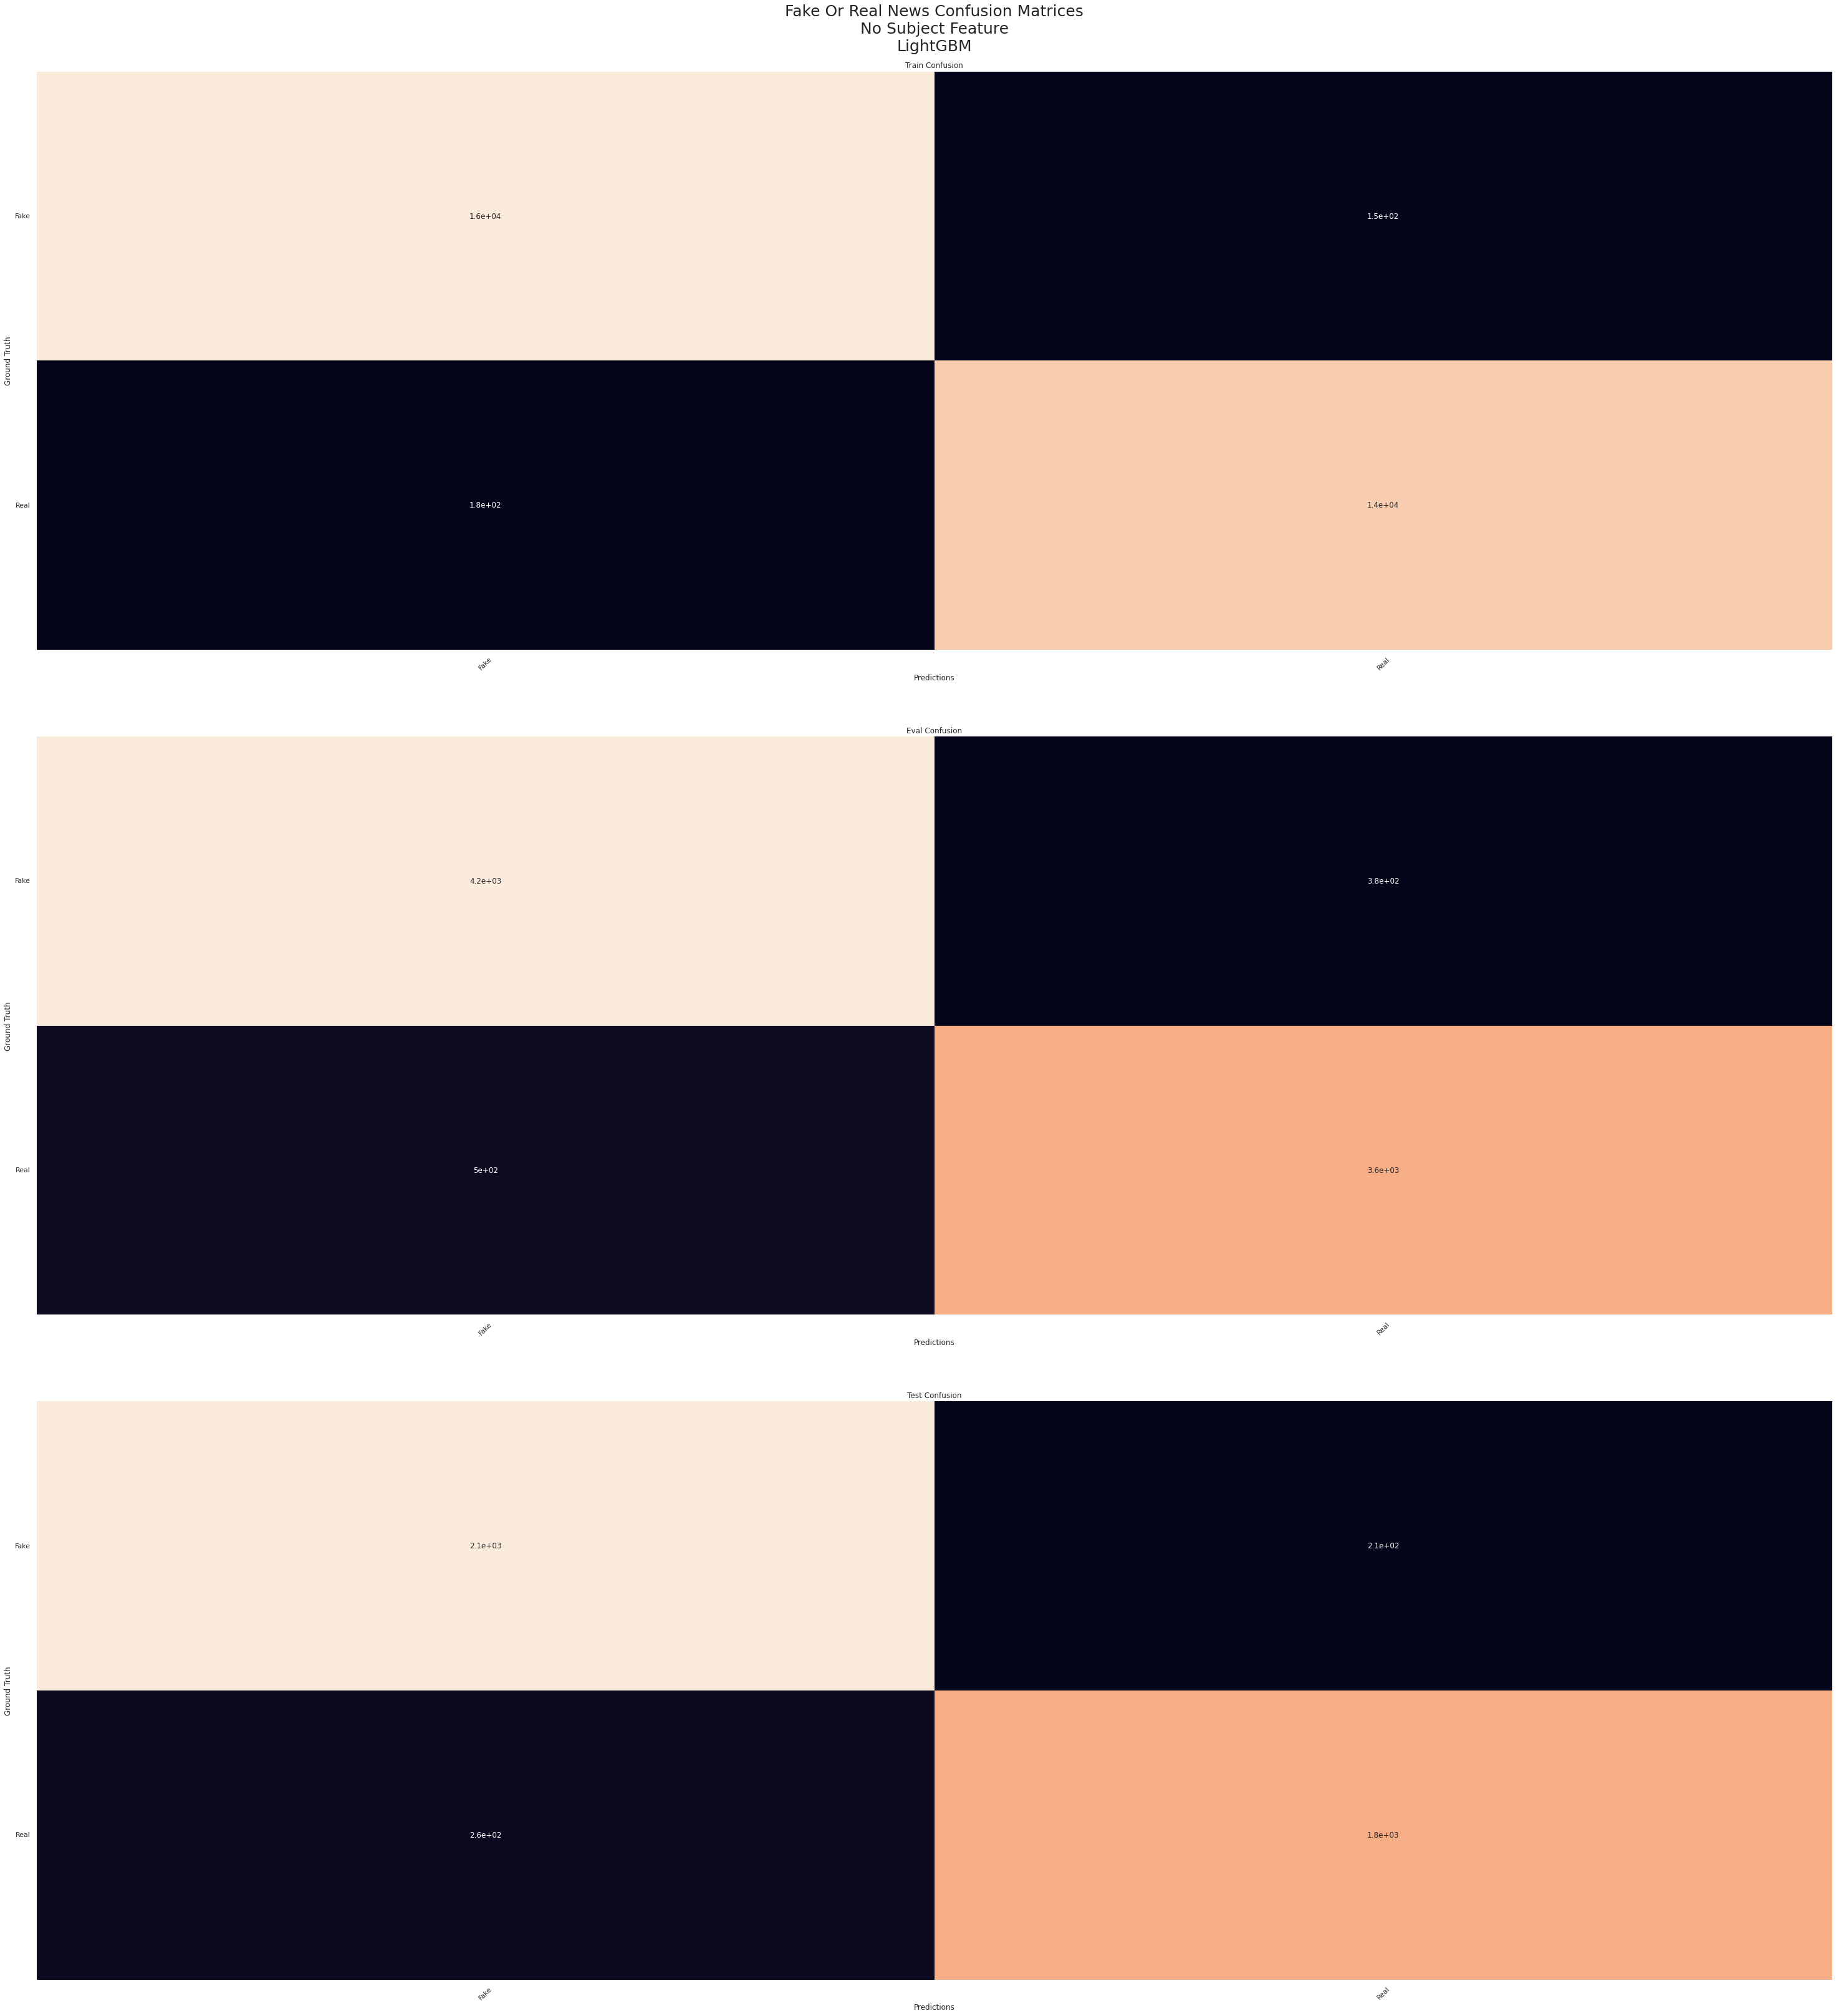

In [31]:
%matplotlib inline
analysis_data = pd.DataFrame()
confusion_matrices = []
for dataset_alias, (dataset_predictions, dataset_labels) in zip(dataset_aliases, zip([train_predictions, eval_predictions, test_predictions], [train_labels, eval_labels, test_labels])):
    report_df = pd.DataFrame(classification_report(dataset_predictions, dataset_labels, output_dict=True)).transpose()
    report_df["dataset_alias"] = dataset_alias
    report_df["label"] = report_df.index
    report_df.replace({"label": {"0": "Fake", "1": "Real"}}, inplace=True)
    analysis_data = pd.concat([analysis_data, report_df])
    confusion_matrices.append(confusion_matrix(dataset_labels, dataset_predictions))
analysis_data.reset_index(inplace=True, drop=True)
analysis_data.head()

grouped_bar_plots = True
sns.set_style()
sns.set_theme()
plot_shape = (2, 2 if grouped_bar_plots else 4)
figure, axes = plt.subplots(plot_shape[0], plot_shape[1])
figure.set_size_inches(30, 15)
for i, dataset_alias in enumerate(dataset_aliases):
    for j, metric_name in enumerate(analysis_data.columns[:4]):
        flat_index = i * j + j
        unraveled_index = np.unravel_index([flat_index], plot_shape)
        ax = axes[unraveled_index[0][0], unraveled_index[1][0]]
        plt.axes(ax)
        ax.set_title(f"{dataset_alias[0].upper()}{dataset_alias[1:]}\n{metric_name}" if not grouped_bar_plots and j == 0 else metric_name)
        ax.set_xlabel("Label")
        ax.set_ylabel("Value")
        ax.set_xticklabels(labels=np.unique(analysis_data["label"].to_numpy()), rotation=90)
        if grouped_bar_plots:
            if i == 0:
                sns.barplot(x=analysis_data["label"].to_numpy(), y=analysis_data[metric_name].to_numpy(), hue=analysis_data["dataset_alias"].to_numpy(), ci="sd", capsize=0.05)
        else:
            sns.barplot(x="label", y=metric_name, data=analysis_data.loc[analysis_data["dataset_alias"] == dataset_alias], ax=ax, ci="sd", capsize=0.05)
    if grouped_bar_plots:
        break
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.85, 
                    wspace=0.1, 
                    hspace=0.35)
figure.suptitle("Fake Or Real News Classification Metrics\nNo Subject Feature\nLightGBM", fontsize=25)
plt.savefig("plots/fake_or_real_news_classification_metrics_xsubject.png")
plt.plot()
figure, axes = plt.subplots(3, 1)
figure.set_size_inches(50, 50)
for i, dataset_alias in enumerate(dataset_aliases):
        ax = axes[i]
        plt.axes(ax)
        ax.set_title(f"{dataset_alias[0].upper()}{dataset_alias[1:]} Confusion")
        sns.heatmap(confusion_matrices[i], annot=True, cbar=False)
        ax.set_xlabel("Predictions")
        ax.set_ylabel("Ground Truth")
        ax.set_xticklabels(labels=["Fake", "Real"], rotation=45)
        ax.set_yticklabels(labels=["Fake", "Real"], rotation=0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.15)
figure.suptitle("Fake Or Real News Confusion Matrices\nNo Subject Feature\nLightGBM", fontsize=25)
plt.savefig("plots/fake_or_real_news_confusion_matrices_xsubject.png")

### Lets analyze some texts with the output

In [32]:
num_articles_to_analyze = 2

# Data setup
news_data = news_data.sample(frac=1)
encoded_titles = data_collator(tokenizer(news_data["title"].to_list()[:num_articles_to_analyze], truncation=True))
tokenized_sentences = []
sentence_counts = []
for _, row in news_data.iloc[:num_articles_to_analyze].iterrows():
    sentences = sent_tokenize(row["text"])
    sentence_counts.append(len(sentences))
    tokenized_sentences.extend(sentences)
encoded_sentences = data_collator(tokenizer(tokenized_sentences, truncation=True))

# Title level feature extraction
titles_dataset = Dataset.from_dict(encoded_titles).to_tf_dataset(
            columns=["attention_mask", "input_ids", "token_type_ids"],
            label_cols=["labels"],
            batch_size=128,
            shuffle=False,
            collate_fn=data_collator
            )
title_outputs = tf.convert_to_tensor(np.array(model.predict(titles_dataset)["logits"]))
title_probabilities = tf.keras.activations.softmax(title_outputs)

# Sentence level feature extraction
document_sentences_dataset = Dataset.from_dict(encoded_sentences).to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["labels"],
        batch_size=128,
        shuffle=False,
        collate_fn=data_collator
        )
sentence_probabilities = tf.keras.activations.softmax(tf.convert_to_tensor(np.array(model.predict(document_sentences_dataset)["logits"])))
text_predictions = []
text_probabilities = []
start_index = 0
for i, sentence_count in enumerate(sentence_counts):
    document_sentence_probabilities = sentence_probabilities[start_index:start_index + sentence_count, :]
    start_index += sentence_count
    top_3_predictions = tf.math.reduce_sum(tf.squeeze(tf.one_hot(tf.nn.top_k(document_sentence_probabilities, 3).indices, tf.shape(document_sentence_probabilities)[1])), axis=0)
    text_predictions.append(tf.math.reduce_sum(top_3_predictions, axis=0) if top_3_predictions.shape[0] == 3 else top_3_predictions)
    text_probabilities.append(tf.math.reduce_sum(document_sentence_probabilities, axis=0))

# Feature construction
article_feats = tf.concat([title_probabilities, text_predictions, text_probabilities], axis=1).numpy()
article_labels = news_data["label"].to_list()[:num_articles_to_analyze]

# Real or Fake News Prediction
article_probabilities = news_model.predict_proba(get_ratio_feats(article_feats))


1/1 [==============================] - 4s 4s/step


In [33]:
def analyze_sentence(text, probabilities):
    probabilities = probabilities.numpy()
    top_3_indices = np.flip(np.argsort(probabilities))[:3]
    print("<", end="")
    print(f"{goemotions_all_labels[top_3_indices[0]]}: {int(probabilities[top_3_indices[0]] * 100)}, {goemotions_all_labels[top_3_indices[1]]}: {int(probabilities[top_3_indices[1]] * 100)}, {goemotions_all_labels[top_3_indices[2]]}: {int(probabilities[top_3_indices[2]] * 100)}", end="")
    print("> ", end="")
    print(f"{text} ", end="")
    print("</>")

start_index = 0
for i, sentence_count in enumerate(sentence_counts):
    print(f"Article {i+1}: ", end="")
    document_sentences = tokenized_sentences[start_index:start_index + sentence_count]
    document_sentence_probabilities = sentence_probabilities[start_index:start_index + sentence_count, :]
    start_index += sentence_count
    analyze_sentence(news_data["title"].iloc[i], title_probabilities[i, :])
    print("\n")
    for j in range(len(document_sentences)):
        analyze_sentence(document_sentences[j], document_sentence_probabilities[j, :])
    prediction_index = np.argmax(article_probabilities[i, :])
    print(f"Prediction: {'Fake' if prediction_index == 0 else 'Real'}: {int(article_probabilities[i, prediction_index] * 100)} Label: {'Fake' if int(article_labels[i]) == 0 else 'Real'}\n\n")

Article 1: <realization: 44, neutral: 36, amusement: 5> Memories in milk bottles: Polish exhibition 'shouts out' annihilation story of Warsaw Ghetto </>


<neutral: 58, realization: 24, approval: 9> WARSAW (Reuters) - A deeply moving exhibition of archives documenting the life and annihilation of Jews by Nazi Germany in the Warsaw Ghetto during World War Two goes on public display in Poland on Thursday. </>
<neutral: 71, approval: 10, realization: 6> The  What We Could Not Shout Out To The World  exhibition will for the first time display original documents prepared and hidden by historian Emanuel Ringelblum and a few dozen helpers who risked their lives in the Ghetto to save whatever was possible for posterity. </>
<neutral: 94, realization: 1, anger: 0> Nazi occupiers in 1940 corralled some 400,000 Jews into a small section of Warsaw most of whom were then sent to camps to be killed or died from the conditions in the Ghetto itself. </>
<disapproval: 27, neutral: 19, anger: 15> The Gh